**Import required libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from random import shuffle
import math

import random
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pickle
from datetime import datetime
import pandas as pd
import sklearn_extra.cluster

In [2]:
def statusPrintInit(input_string):
    print("[STATUS]: Initializing", input_string)
    
def statusPrintEndInit(input_string):
    print("[STATUS]: Done with", input_string)

def statusPrintPlain(input_string):
    print("[STATUS]:", input_string)


In [3]:
class Connect2Model(nn.Module):

    def __init__(self, board_size, action_size, device):

        super(Connect2Model, self).__init__()

        self.device = device
        self.size = board_size
        self.action_size = action_size

        self.fc1 = nn.Linear(in_features=self.size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)

        # Two heads on our network
        self.action_head = nn.Linear(in_features=64, out_features=self.action_size)
        self.value_head = nn.Linear(in_features=64, out_features=1)

        self.to(device)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        action_logits = self.action_head(x)
        value_logit = self.value_head(x)

        return F.softmax(action_logits, dim=1), value_logit

    def predict(self, board):
        board = torch.FloatTensor(board.astype(np.float32)).to(self.device)
        board = board.view(1, self.size)
        self.eval()
        with torch.no_grad():
            pi, v = self.forward(board)

        return pi.data.cpu().numpy()[0], v.data.cpu().numpy()[0]

In [4]:
import os
import numpy as np
from random import shuffle

import torch
import torch.optim as optim

class Trainer:

    def __init__(self, dl_model , model, args):
        self.dl_model = dl_model
        self.model = model
        self.args = args
        self.mcts = MCTS_DL(self.dl_model, self.model, self.args)
        self.scores_mcts_dl = np.array([])
        self.scores_greedy = np.array([])
        self.scores_random = np.array([])
        self.scores_mcts = np.array([])

    def exceute_episode(self, tmp, plotting):

        train_examples = []
        state = []

        while True:

            self.mcts = MCTS_DL(self.dl_model, self.model, self.args)
            root = self.mcts.run(state)

            action_probs = [0 for _ in range(self.model.n_clusters)]
            for k, v in root.children.items():
                action_probs[k] = v.visit_count

            action_probs = action_probs / np.sum(action_probs)
            train_examples.append((state, action_probs))

            action = root.select_action(temperature = tmp) # Action here is returned as an index of the action within the model.representatives list
            state = self.model.get_next_state(state, action) # This is where you actually get the song from the chosen cluster (selected in select_action) and 
            reward = self.model.get_reward(state)

            if reward is not None:
                ret = []
                for hist_state, hist_action_probs in train_examples:
                    # [Board, actionProbabilities, Reward]
                    ret.append((self.model.state_to_input(hist_state), hist_action_probs, reward))
                print(hist_state, reward)
                
                if plotting:
                    self.scores_mcts_dl = np.append(self.scores_mcts_dl, reward)
                    self.scores_greedy = np.append(self.scores_greedy, get_greedy_trajectory(self.model))
                    self.scores_random = np.append(self.scores_random, get_random_trajectory(self.model))
                    self.scores_mcts = np.append(self.scores_mcts, get_MCTS_trajectory(self.model))
                    plt.plot(self.scores_mcts_dl, label='DeepMCTS')
                    plt.plot(self.scores_mcts, label='Vanilla MCTS')
                    plt.plot(self.scores_greedy, label='Greedy policy')
                    plt.plot(self.scores_random, label='Random policy')
                    plt.legend()
                    plt.show()
                    
                return ret

    def learn(self, temperature):
        for i in range(1, self.args['numIters'] + 1):

            print("{}/{}".format(i, self.args['numIters']))

            train_examples = []

            for eps in range(self.args['numEps']):
                iteration_train_examples = self.exceute_episode(temperature, False)
                train_examples.extend(iteration_train_examples)

            self.exceute_episode(0, True)
            shuffle(train_examples)
            self.train(train_examples)
            filename = self.args['checkpoint_path']
            self.save_checkpoint(folder=".", filename=filename)

    def train(self, examples):
        optimizer = optim.Adam(self.dl_model.parameters(), lr=5e-4)
        pi_losses = []
        v_losses = []

        for epoch in range(self.args['epochs']):
          self.dl_model.train()

          batch_idx = 0

          while batch_idx < int(len(examples) / self.args['batch_size']):
            sample_ids = np.random.randint(len(examples), size=self.args['batch_size'])
            boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
            boards = torch.FloatTensor(np.array(boards).astype(np.float64))
            target_pis = torch.FloatTensor(np.array(pis))
            target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))

            # predict
            boards = boards.contiguous().cuda()
            target_pis = target_pis.contiguous().cuda()
            target_vs = target_vs.contiguous().cuda()

            # compute output
            out_pi, out_v = self.dl_model(boards)
            l_pi = self.loss_pi(target_pis, out_pi)
            l_v = self.loss_v(target_vs, out_v)
            total_loss = l_pi + l_v

            pi_losses.append(float(l_pi))
            v_losses.append(float(l_v))

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            batch_idx += 1
    

          print()
          print("Policy Loss", np.mean(pi_losses))
          print("Value Loss", np.mean(v_losses))
          # print("Examples:")
          # print(out_pi[0].detach())
          # print(target_pis[0])
          

    def loss_pi(self, targets, outputs):
        loss = -(targets * torch.log(outputs)).sum(dim=1)
        return loss.mean()

    def loss_v(self, targets, outputs):
        loss = torch.sum((targets-outputs.view(-1))**2)/targets.size()[0]
        return loss

    def save_checkpoint(self, folder, filename):
        if not os.path.exists(folder):
            os.mkdir(folder)

        filepath = os.path.join(folder, filename)
        torch.save({
            'state_dict': self.dl_model.state_dict(),
        }, filepath)

In [5]:
import pandas as pd
import os
import numpy as np
import itertools
import scipy.spatial.distance as distlib
import random as rand

class RecommendationSystem:
    def __init__(self, dataset_with_bins, n_features, n_bins):
        '''
        We assume here that the columns of the dataset here are already the binary percentile bins for all features 
        For sanity check: n_features x n_bins = length(dataset_with_bins)
        '''
        statusMsg = 'recommendation system class'
        statusPrintInit(statusMsg)
        self.data = dataset_with_bins # assuming this is the whole dataset split that we want to work with
        self.data.index = np.arange(np.shape(self.data)[0])
        self.n_features = n_features
        self.n_bins = n_bins
        self.k_t = 10 # for now, just queue the user 10 songs to choose from
        self.k_s = 10
        self.var_param = 100 # parameter that determines the "variance" of the user reference distribution that the user song picks are generated from
        self.initial_songs = self.gen_user_song_picks() # assuming this is still a pandas df of k_s rows, but only containing the song rows that the user prefers
        
        # Initialize preferences
        self.init_song_preferences()
        self.init_transition_preferences()
        statusPrintEndInit(statusMsg)

    def init_song_preferences(self):
        statusMsg = "song preferences"
        statusPrintInit(statusMsg)
        # Initialize preference array
        self.phi_s = (1/((self.k_s + 1) * self.n_bins)) * np.ones((self.n_features * self.n_bins, 1))
        tmp = (np.sum(self.initial_songs.values, axis = 0)) * (1/(self.k_s + 1))
        self.phi_s = self.phi_s + np.reshape(tmp, (len(tmp), 1))
        statusPrintEndInit(statusMsg)

    def theta_t(self, idx_a, idx_b):
        '''
        Input: indices of songs a and b within the provided dataset (int)

        Output: vector theta_t, assuming the feature sequence of 1-i, 1-2, ..., 1-n_bins, 2-1, ..., n_bins-1, n_bins-2, ..., n_bins-n_bins
        '''
        indices = np.array([], dtype=int)
        for i in range(self.n_features):
            a_bin_idx = np.where(self.data.loc[idx_a][self.data.columns[i*self.n_bins:(i+1)*self.n_bins]] == 1.0)[0]
            b_bin_idx = np.where(self.data.loc[idx_b][self.data.columns[i*self.n_bins:(i+1)*self.n_bins]] == 1.0)[0]
            indices = np.append(indices, int(i*(self.n_bins*self.n_bins) + a_bin_idx*self.n_bins + b_bin_idx))
        out = np.zeros((self.n_bins * self.n_bins * self.n_features, 1))
        out[indices] = 1
        return out

    def init_transition_preferences(self):
        statusMsg = "transition preferences"
        statusPrintInit(statusMsg)
        # Take the upper-median preference split
        self.Rs = np.sum(np.matmul(self.data.values, self.phi_s), axis=1)
        self.Mstar = self.data.copy()
        self.Mstar['Rs'] = self.Rs
        self.Mstar.sort_values('Rs', inplace = True, ascending = False)
        self.Mstar = self.Mstar[:np.shape(self.Mstar)[0] // 2]
        self.Mstar['old_index'] = self.Mstar.index
        self.Mstar.index = np.arange(np.shape(self.Mstar)[0])

        # Generate 10th percentile distance of all pairwise distances from M (not M*)
        self.diff = distlib.pdist(self.data.values, 'cosine')
        self.delta = np.percentile(self.diff, 10, axis=0)
        self.distances = distlib.squareform(self.diff)
        np.fill_diagonal(self.distances, np.inf)

        # Generate a representative subset of M*
        self.representatives, self.clusters_t = self.delta_medoids(self.Mstar, self.delta, True)
        song_prev = np.random.choice(self.representatives)

        if self.k_t > len(self.representatives):
            print("[WARNING] k_t parameter too large for generated representative subset. Consider using a larger dataset or reducing k_t value")
            print("Setting k_t =", len(self.representatives), "to match the generated number of representatives through delta-medoids")
            self.k_t = len(self.representatives)

        song_prev = np.random.choice(self.representatives)
        self.representatives = np.delete(self.representatives, np.argwhere(self.representatives == song_prev))

        self.phi_t = (1/(self.k_t * self.n_bins*self.n_bins)) * np.ones((self.n_features * self.n_bins * self.n_bins, 1))

        for i in range(self.k_t-1):
            next_song, theta = self.pick_next_song(song_prev, self.user_ref_samples_t[:, i])
            self.phi_t += (1/(self.k_t)) * theta
            song_prev = next_song
            
        statusPrintEndInit(statusMsg)

 

    def one_shot_delta(self, data, delta, clusters, init):
        # Remember to change the distance metric in case we change delta distance definition
        if init:
            distances = distlib.pdist(data[data.columns[:-2]], 'cosine')
        else:
            distances = distlib.pdist(data, 'cosine') # Same as for delta medoids method
        distances = distlib.squareform(distances)
        representatives_init = np.array(list(clusters.keys()), dtype = 'int32')
        clusters = dict(zip(representatives_init, [np.array([], dtype='int32') for _ in range(len(representatives_init))])) # We want to start with a dictionary with the keys being there, but the elements being empty, as all elements will be reassigned anyways
        for index, row in data.iterrows():
            dist = 1e6
            representatives = np.array(list(clusters.keys()), dtype = 'int32')
            if len(representatives) > 0:
                rep = np.intersect1d(np.where(distances[:, index] == np.min(distances[:, index][representatives]))[0], representatives) # Take the intersection to make sure we select the correct index belonging to the set of representatives
                
                if len(rep) > 1:
                    if index not in rep: # Check if already in rep --> we do not want to add it to another cluster if it is already a representative (in case index and another song have the same feature vectors, miraculously)
                        rep = rep[0]
                    else:
                        rep = index
                else:
                    rep = int(rep)
                dist = distances[rep, index]
            if dist <= delta:
                clusters[rep] = np.append(clusters[rep], index)
            else: 
                clusters[index] = np.array([index])

        dbg = np.sum([len(val) for val in clusters.values()])
        if dbg != np.shape(data)[0]:
            print("WARNING: stuff going wrong here, generated list of cluster elements does not sum up to the total size of the song dataset selected")
        return clusters

    def delta_medoids(self, data, delta, init):
        statusMsg = "delta medoids"
        statusPrintInit(statusMsg)
        if init:
            distances = distlib.pdist(data[data.columns[:-2]], 'cosine')
        else:
            distances = distlib.pdist(data, 'cosine') # When we want to use it to generate normal clusters of the whole dataset - we do not have anything appended, so use all columns
        distances = distlib.squareform(distances)
        np.fill_diagonal(distances, 0)
        exit_loop = False
        i = 0
        clusters = {}
        while not exit_loop:
            i +=1
            clusters = self.one_shot_delta(data, delta, clusters, init)
            if 1 != i:
                representatives_prev = representatives
            else:
                representatives_prev = np.array([], dtype = 'int32')
            representatives = np.array([], dtype = 'int32')
            for cluster in clusters.items():
                cluster = cluster[1]
                cluster_dists = distlib.pdist(data.loc[cluster], 'cosine')
                cluster_dists = distlib.squareform(cluster_dists)
                argmin = np.argmin(np.sum(cluster_dists, axis=0))
                representatives = np.append(representatives, cluster[argmin])
            
            if np.array_equal(np.sort(representatives), np.sort(representatives_prev)):
                exit_loop = True
                

        # Convert back to indices of the original data array
        if init:
            representatives = data['old_index'][np.in1d(data.index, representatives)].values # Do not need to convert back if clustering songs together for action space reduction, as we preserve the old indices anyways
        statusPrintEndInit(statusMsg)
        return representatives, clusters

    def pick_next_song(self, previous_song, reference):
        reference = np.reshape(reference, (len(reference), 1))
        min_dist = 1e06
        for song in self.representatives:
            theta_current = self.theta_t(previous_song, song)
            dist = distlib.cosine(theta_current, reference)
            if dist < min_dist:
                min_theta = theta_current
                min_song = song
                min_dist = dist

        self.representatives = np.delete(self.representatives, np.argwhere(self.representatives == min_song)[0])
        return min_song, min_theta
    
    def gen_user_song_picks(self):
        """
        Returns a subset of the dataframe of k_s songs closest to the random samples generated from the user preference distribution, simulating picked user reference
        The user reference distribution is generated here and can be accessed through self.user_ref
        """
        self.user_ref_s, self.user_ref_samples_s, self.user_ref_t, self.user_ref_samples_t  = self.gen_user_ref()
        sample_index = np.arange(np.shape(self.data)[0], np.shape(self.data)[0] + self.k_s, dtype='int32')
        to_append = pd.DataFrame(np.transpose(self.user_ref_samples_s), index = sample_index)
        sample = self.data.copy().append(to_append)
        dists_with_samples = distlib.pdist(sample, metric='cosine')
        dists_with_samples = distlib.squareform(dists_with_samples)
        np.fill_diagonal(dists_with_samples, np.inf)
        user_selected_songs = np.array([], dtype='int32')

        for i in sample_index:
            min_ind = np.argmin(dists_with_samples[:sample_index[0], i])
            user_selected_songs = np.append(user_selected_songs, min_ind)
            dists_with_samples[min_ind, :] = np.inf #Do not allow to pick this row anymore
        return self.data.loc[user_selected_songs]
        

    def gen_user_ref(self):
        '''
        Generates a random "ground-truth" user song and transitions preference distributions over features (kind of
        like a ground-truth phi_s and phi_t), as well as k_s for songs (and k_t, for transitions, respectively) samples from it, that are later used to 
        simulate user song preferences and transition preferences that the user preference vectors phi_s and phi_t are learned from

        Input: var_param: a parameter that alters the variance of the distribution over each feature of the ground truth user preference vectors, int

        Output: - user_reference_s (numpy array, n_bins x n_features, 1): ground-truth user song preference distribution over each feature
                - user_samples_s (numpy array, n_bins x n_features, k_s): k_s samples of the "ground truth phi_s", used to select initial, user-preferred songs
                - user_reference_t (numpy array, n_bins*n_bins x n_features, 1): ground-truth user transition preference distribution over each feature
                - user_samples_t (numpy array, n_bins*n_bins x n_features, k_t): k_t samples of the "ground truth phi_t", used to select songs that the user preference phi_t will be estimated from 
        '''
    
        user_reference_s = np.array([])
        user_reference_t = np.array([])

        user_samples_s = np.zeros((self.n_features * self.n_bins, self.k_s))
        user_samples_t = np.zeros((self.n_features * self.n_bins * self.n_bins, self.k_t))

        for i in range(self.n_features):
            vec_s = np.random.randint(1, self.var_param, (self.n_bins, ))
            vec_s = vec_s/np.sum(vec_s)
            user_reference_s = np.append(user_reference_s, vec_s)
            sample_bins_s = np.array(rand.choices(np.arange(self.n_bins, dtype='int32'), vec_s, k = self.k_s))
            user_samples_s[i*self.n_bins + sample_bins_s, np.arange(self.k_s, dtype='int32')] = 1
            
            vec_t = np.random.randint(1, self.var_param, (self.n_bins * self.n_bins, ))
            vec_t = vec_t/np.sum(vec_t)
            user_reference_t = np.append(user_reference_t, vec_t)
            sample_bins_t = np.array(rand.choices(np.arange(self.n_bins * self.n_bins, dtype='int32'), vec_t, k = self.k_t))
            user_samples_t[i*self.n_bins*self.n_bins + sample_bins_t, np.arange(self.k_t, dtype='int32')] = 1

        return user_reference_s, user_samples_s, user_reference_t, user_samples_t

In [6]:
def ucb_score(parent, child):
    """
    The score for an action that would transition between the parent and child.
    """
    if child.prior < 0.0001:
      return -100000000
    prior_score = child.prior * math.sqrt(parent.visit_count) / (child.visit_count + 1)
    if child.visit_count > 0:
        # The value of the child is from the perspective of the opposing player
        value_score = child.value()
    else:
        value_score = 100000

    return value_score + prior_score

In [7]:
class MDP:
    def __init__(self, file_name, playlist_length, n_clusters):
        statusMsg = "MDP  class"
        statusPrintInit(statusMsg)
        df = pd.read_csv(file_name, index_col=None)

        self.features = ['duration', 'key_confidence', 'end_of_fade_in', 'mode_confidence', 'start_of_fade_out', 'tempo',
                    'artist_hotttnesss', 'song_hotttnesss']

        for feature in self.features:
          filter = df[feature] > 0
          df = df[filter]
        
        self.filtered_df = df[self.features]
        self.filtered_df.dropna(inplace=True)

        # self.filtered_df = self.filtered_df.head(100)
        
        self.n_clusters = n_clusters
        self.filtered_df = self.filtered_df.reset_index(drop=True)
        self.n_rows = len(self.filtered_df.index)
        self.n_songs = self.n_rows
        self.n_bins = 10
        self.n_features = len(self.features)
        self.id_song_to_vec = dict()
        self.songs = set()        
        self.song_id_to_song_row = []
        self.cluster_priors = []
        self.playlist_length = playlist_length
        self.id_song_to_features = dict()

        song_id = 0

        statusPrintPlain("generating feature vectors")
        for song, row in self.filtered_df.iterrows():
            self.id_song_to_vec[song_id] = np.zeros(80)
            self.id_song_to_features[song_id] = np.zeros(self.n_features)

            for f in range(self.n_features):
              feature = self.features[f]
              self.id_song_to_features[song_id][f] = row[feature]

            self.songs.add(song_id)
            self.song_id_to_song_row.append(row)
            song_id += 1

        self.cluster_priors = np.ones(self.n_clusters)

        self.songs_list = [i for i in range(self.n_songs)]

        for f in range(self.n_features):

            feature = self.features[f]
            sorted_df = self.filtered_df.sort_values(by=[feature])
            i = 0
            for idx, row in sorted_df.iterrows():
                bin = i * self.n_bins // self.n_rows
                self.id_song_to_vec[idx][f * 10 + bin] = 1
                i += 1


        df_input = pd.DataFrame.from_dict(self.id_song_to_vec, orient='index')
        # Select songs that the user prefers (randomly selecting 5 for now, change later)
        self.init_prefs = df_input.loc[rand.sample(self.songs, 5)]

        self.rs = RecommendationSystem(df_input, self.n_features, self.n_bins)
        self.phi_s = self.rs.phi_s.reshape(80)
        self.phi_t = self.rs.phi_t.reshape(800)
        self.delta_action_clustering = self.rs.delta # Try out this delta for now 

        statusPrintPlain("Generating song clusters for action space reduction")
        km = sklearn_extra.cluster.KMedoids(n_clusters = self.n_clusters).fit(self.filtered_df.values)
        self.representatives = km.medoid_indices_
        self.cluster_assignment = km.labels_
        self.clusters = dict(zip(km.medoid_indices_, [np.where(km.labels_ == rep_idx)[0] for rep_idx in range(len(km.medoid_indices_))]))

        self.transition_reward = np.zeros((self.n_songs, self.n_songs))

        statusPrintPlain("Fetching the pre-computed song transition rewards")
        self.transition_reward = np.load('./data/transition_rewards.npy') # Replaced this by a pre-computed file with the whole 2886 cleaned-up dataset included, as otherwise it takes 50 minutes to compute this every time
        self.song_reward = np.zeros(self.n_songs)
        for i in range(self.n_songs):
          self.song_reward[i] = np.dot(self.phi_s, self.theta_s(i))

        statusPrintEndInit(statusMsg)

    def get_next_state(self, state, action):
      action = self.representatives[action] # The input action is actually the index of the representative cluster, not the song number of the representative of the cluster (as generated through node.expand())
      select_from = np.array(list(set(self.clusters[action]) - set(state)))
      next_idx = np.random.randint(0, len(select_from)) 
      self.next_song = select_from[next_idx] # We save it locally within the class as we make use of it in some instances after calling the method
      return state + [self.next_song]


    def get_valid_random_cluster_index(self, current_state):
        action = np.random.choice(np.arange(self.n_clusters))
        if np.array(list(set(self.clusters[self.representatives[action]]) - set(current_state))).size == 0:
            self.get_valid_random_cluster_index(current_state)
        else:
          return action
      
    def get_valid_actions(self, state):
        # All actions are invalid by default
        valid_actions = [0] * self.n_clusters
        i = 0

        for rep in self.clusters.keys():
            if np.array([set(self.clusters[rep]) - set(state)]).size != 0: # Check if each cluster still has songs that have not been selected in the playlist yet
                valid_actions[i] = 1
                i += 1

        return valid_actions

    def get_song_cluster(self, song):
        return self.representatives[self.cluster_assignment[song]]

    def state_to_input(self, state):
      input = np.ones(self.playlist_length*self.n_features*10)*-1
      for i in range(len(state)):
        song = state[i]
        input[i*self.n_features*10:(i+1)*self.n_features*10] = self.id_song_to_vec[song]
      return input

    def get_reward(self, final_state):
      if len(final_state) < self.playlist_length:
        return None
      elif len(final_state) == self.playlist_length:
        state = []
        trajectory_states = [state]
        trajectory_actions = []
        
        for song in final_state:
          state.append(song)
          trajectory_states.append(state)
          trajectory_actions.append(song)
          
        return self.payoff_trajectory(trajectory_states, trajectory_actions)

      else:
        print("Error: length > self.playlist_length")
        return None


    def get_theta_t(self, s1, s2):
        theta_t = np.zeros(800)
        for f in range(len(self.features)):
            for i in range(10):
                for j in range(10):
                    if self.id_song_to_vec[s1][f*10 + i] == 1 and  self.id_song_to_vec[s2][f*10 + j]:
                        theta_t[f*100 + i*10 + j] = 1
        return  theta_t

    def theta_s(self, s):
        return self.id_song_to_vec[s]

    def R(self, s, a):
        Rs = self.song_reward[a]
        Rt = 0
        for i in range(len(s)):
            song_past = s[len(s)-i-1]
            Rt += 1/((i+1)**(0.1)) * self.transition_reward[song_past,a]
        return Rs + Rt


    def payoff_trajectory(self, trajectory_states, trajectory_actions):
      payoff = 0

      for t in range(len(trajectory_actions)):
        payoff +=  self.R(trajectory_states[t], trajectory_actions[t])
      return payoff

    def MC_value(self, s):
      count = 0
      sum_values = 0
      state = s
      # Past episodes
      episode_states = [[]]
      episode_actions = []

      for i in range(model.playlist_length):
        if i < len(s):
          state = s[:i+1]
          action = s[i]
        else:
          action_probs = list(self.cluster_priors)
          j = 0
          for cluster_id in self.clusters.keys():
            if np.in1d(self.clusters[cluster_id], state).all():
              action_probs[j] = 0
            j += 1

          action_probs = np.array(action_probs)/np.sum(np.array(action_probs))
          action_cluster = np.random.choice(list(self.clusters.keys()), 1, p = action_probs)[0]
          action = np.random.choice(self.clusters[action_cluster])
          state = episode_states[-1] + [action]

        episode_states.append(state)
        episode_actions.append(action)

      # print("MC estimate:", s, episode_states, episode_actions)
          
      # Set MC 
      payoff = self.payoff_trajectory(episode_states, episode_actions)
      
      return payoff

class Node:
    def __init__(self, prior):
        self.visit_count = 0
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.state = None

    def expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def select_action(self, temperature):
        """
        Select action according to the visit count distribution and the temperature.
        """
        visit_counts = np.array([child.visit_count for child in self.children.values()])
        actions = [action for action in self.children.keys()]
        
        if temperature == 0:
            action = actions[np.argmax(visit_counts)]

        elif temperature == float("inf"):
            action = np.random.choice(actions)

        else:
            # See paper appendix Data Generation
            visit_count_distribution = visit_counts ** (1 / temperature)
            visit_count_distribution = visit_count_distribution / sum(visit_count_distribution)
            action = np.random.choice(actions, p=visit_count_distribution)


        # The action returned here would be the index of the cluster in which the selected song resides
        return action

    def select_child(self):
        """
        Select the child with the highest UCB score.
        """
        best_score = -np.inf
        best_action = -1
        best_child = None

        for action, child in self.children.items():
            score = ucb_score(self, child)
            if score > best_score:
                best_score = score
                best_action = action
                best_child = child

        return best_action, best_child

    def expand(self, state, action_probs):
        """ 
        We expand a node and keep track of the prior policy probability given by neural network
        We return the cluster index (the index of the representative cluster song within model.representatives list)
        """
        self.state = state
        for cluster_idx in range(len(action_probs)):
              self.children[cluster_idx] = Node(action_probs[cluster_idx])

    def __repr__(self):
        """
        Debugger pretty print node info
        """
        prior = "{0:.2f}".format(self.prior)
        return "{} Prior: {} Count: {} Value: {}".format(self.state.__str__(), prior, self.visit_count, self.value())


In [8]:
import torch
import math
import numpy as np

class MCTS_DL:

    def __init__(self, dl_model, model, args):
        self.dl_model = dl_model
        self.model = model
        self.args = args

    def run(self, state):
        root = Node(0)

        # EXPAND root
        action_probs, value = self.dl_model.predict(self.model.state_to_input(state))
        valid_actions = self.model.get_valid_actions(state)
        action_probs = action_probs * valid_actions  # mask invalid moves
        action_probs /= np.sum(action_probs)
        root.expand(state, action_probs)

        for _ in range(self.args['num_simulations']):
            node = root
            search_path = [node]

            # SELECT
            while node.expanded():
                action, node = node.select_child()
                search_path.append(node)

            parent = search_path[-2] # Parent of the current node, non-expanded
            state = parent.state 

            # Above until here, we are just traversing the tree over nodes that we have already visited before. Afterwards, we select a node 

            # Now we're at a leaf node and we would like to expand
            # Players always play from their own perspective
            next_state = self.model.get_next_state(state, action)
            # Get the board from the perspective of the other player

            # The value of the new state from the perspective of the other player
            value = self.model.get_reward(next_state)
            if value is None:  # Is this is not supposed to be a while loop instead of a conditional? Otherwise one simulation will just always stop at a leaf node + 1, instead of the actual playlist length --> no guarantee that we have explored any path of length that is equal to the playlist length within the number of simulations
                # If the game has not ended:
                # EXPAND

                action_probs, value = self.dl_model.predict(self.model.state_to_input(next_state))
                valid_actions = self.model.get_valid_actions(next_state)

                action_probs = action_probs * valid_actions  # mask invalid moves
                action_probs /= np.sum(action_probs)

                node.expand(next_state, action_probs)

            self.backpropagate(search_path, value)

        return root

    def backpropagate(self, search_path, value):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        for node in reversed(search_path):
            node.value_sum += value 
            node.visit_count += 1

In [9]:
class MCTS:

    def __init__(self, model, args):
        self.model = model
        self.args = args

    def run(self, root_state):
        print("")
        root = Node(0)
        # EXPAND root
        action_probs = list(self.model.cluster_priors)
        i = 0

        for cluster_id in self.model.clusters.keys():
            if self.model.clusters[cluster_id].size == 0:
                action_probs[i] = 0
            i += 1
        
        action_probs /= np.sum(action_probs)
        root.expand(root_state, action_probs)

        for _ in range(self.args['num_simulations']):

            node = root
            search_path = [node]

            # SELECT
            while node.expanded():              
                action, node = node.select_child()
                search_path.append(node)
            parent = search_path[-2]
            state = parent.state
            # # Now we're at a leaf node and we would like to expand
            # # Players always play from their own perspective
            # next_state, _ = self.game.get_next_state(state, action=action)
            # # Get the board from the perspective of the other player
            # next_state = self.game.get_canonical_board(next_state, )

            # The value of the new state from the perspective of the other player
            # value = self.game.get_reward_for_player(next_state)
            next_state = parent.state + [action]

            value = model.MC_value(next_state)

            action_probs = list(self.model.cluster_priors)
            k = 0

            for cluster_id in self.model.clusters.keys():
                if np.array(list(set(self.model.clusters[cluster_id]) - set(next_state))).size == 0:
                    action_probs[k] = 0
                k += 1

            node.expand(next_state, action_probs)
        

            # if value is None:
                # If the game has not ended:
                # EXPAND
                # action_probs, value = model.predict(next_state)
                # valid_moves = self.game.get_valid_moves(nesxt_state)
                # action_probs = action_probs * valid_moves  # mask invalid moves
                # action_probs /= np.sum(action_probs)
                # node.expand(next_state, action_probs)

            self.backpropagate(search_path, value)

        return root

    def backpropagate(self, search_path, value):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        for node in reversed(search_path):
            node.value_sum += value
            node.visit_count += 1


In [14]:
def get_random_trajectory(model):
  state = []
  trajectory_states = [state]
  trajectory_actions = []

  for i in range(playlist_length):

    action = model.get_valid_random_cluster_index(state)
    state = model.get_next_state(state, action)

    trajectory_states.append(state)
    trajectory_actions.append(model.next_song)

  cum_rewards = model.payoff_trajectory(trajectory_states, trajectory_actions)
  return cum_rewards

def get_greedy_trajectory(model):
  state = []
  trajectory_states = [state]
  trajectory_actions = []
  
  for i in range(playlist_length):
    max_score = -np.inf
    max_action = -1
    for try_action in range(model.n_clusters):
      if np.array(list(set(model.clusters[model.representatives[try_action]]) - set(state))).size == 0:
        continue #Skip if cluster associated with try_action is empty
      else: 
        try_state = model.get_next_state(state, try_action)
        try_trajectory_states = list(trajectory_states)
        try_trajectory_actions = list(trajectory_actions)
        try_trajectory_states.append(try_state)
        try_trajectory_actions.append(model.next_song)
        score = model.payoff_trajectory(try_trajectory_states, try_trajectory_actions)

        if score > max_score:
          max_song = model.next_song # saved within the MDP class when get_next_state is called
          max_score = score
    
    state.append(max_song)
    trajectory_states.append(state)
    trajectory_actions.append(max_song)

  cum_rewards = model.payoff_trajectory(trajectory_states, trajectory_actions)

  return cum_rewards

def get_MCTS_trajectory(model):
  # MCTS

  mcts = MCTS(model, args)
  trajectory_states = [[]]
  trajectory_actions = []
  state = []

  for i in range(playlist_length):
    root = mcts.run(state)
    counts = [node.visit_count for node in root.children.values()]
    max_val = max(counts)
    cluster_id = counts.index(max_val)
    state = model.get_next_state(state, cluster_id)
    song = model.next_song
    trajectory_states.append(state)
    trajectory_actions.append(song)
    # print(counts, max_index, state)
    for action, child in root.children.items():
      score = ucb_score(root, child)
      # print(child.state, score)

  cum_rewards =  model.payoff_trajectory(trajectory_states, trajectory_actions)
  return cum_rewards

[STATUS]: Initializing MDP  class
[STATUS]: generating feature vectors


/tmp/ipykernel_4865/1447988323.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.filtered_df.dropna(inplace=True)


[STATUS]: Initializing recommendation system class
[STATUS]: Initializing song preferences
[STATUS]: Done with song preferences
[STATUS]: Initializing transition preferences
[STATUS]: Initializing delta medoids
[STATUS]: Done with delta medoids
[STATUS]: Done with transition preferences
[STATUS]: Done with recommendation system class
[STATUS]: Generating song clusters for action space reduction
[STATUS]: Fetching the pre-computed song transition rewards
[STATUS]: Done with MDP  class
1/50
[2703, 1519, 972, 2315, 380, 667, 2631, 2553, 66] 14.339717073074382
[508, 1675, 375, 2080, 1582, 2447, 1810, 308, 697] 17.29781929029476
[31, 2294, 582, 194, 1391, 425, 2781, 1858, 1307] 16.381439681501934
[282, 376, 2767, 1484, 1388, 1565, 498, 2726, 2792] 14.516653925864256
[2144, 842, 151, 1173, 2391, 2326, 2055, 1238, 2843] 14.404247988414218
[1299, 1295, 1975, 618, 636, 1602, 1243, 1674, 2074] 13.985093533471998
[2106, 2266, 1724, 1340, 2418, 1783, 458, 1746, 1556] 18.232919120993902
[2506, 613,

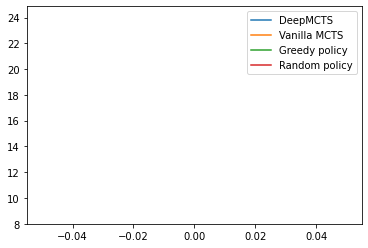


Policy Loss 2.9122554461161294
Value Loss 230.0983912150065

Policy Loss 2.876353124777476
Value Loss 212.40652084350586
2/50
[899, 179, 636, 2259, 1379, 1731, 1391, 2720, 1956] 19.862195883348907
[151, 1611, 2239, 1790, 1694, 220, 293, 1318, 1369] 14.056564701958433
[2629, 1317, 2348, 1887, 2816, 2107, 1683, 2743, 2860] 15.839447662967208
[105, 2820, 259, 1074, 992, 1774, 1897, 2488, 2177] 15.053665937615245
[1101, 648, 1902, 1161, 2452, 2635, 1017, 2358, 567] 17.564743172909335
[629, 2832, 2514, 2027, 2254, 469, 501, 2005, 2681] 12.97380209259878
[2128, 1655, 1237, 2418, 1197, 2247, 2750, 1176, 39] 15.409023867432225
[1618, 1821, 1887, 1974, 265, 2345, 2333, 149, 303] 16.420426217453084
[1823, 1549, 1923, 1361, 2675, 2202, 1288, 1965, 2391] 16.497146166036153
[211, 1918, 259, 1324, 401, 2246, 1571, 2359, 936] 12.783651323216407
[2265, 1196, 2812, 2413, 1385, 2869, 503, 1988, 39] 10.166147512498789












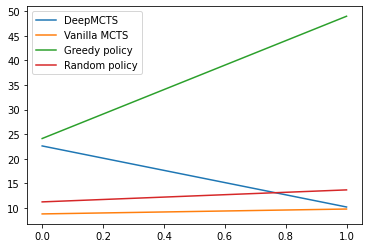


Policy Loss 2.696717540423075
Value Loss 151.76721700032553

Policy Loss 2.6875582337379456
Value Loss 126.8597583770752
3/50
[1659, 1562, 573, 2650, 1086, 1489, 162, 801, 2301] 12.572498171740653
[871, 587, 2000, 2246, 790, 2697, 699, 2173, 669] 11.480901051531033
[1047, 2495, 2436, 2237, 1630, 1756, 1176, 209, 978] 14.401413094880734
[1491, 1103, 2483, 1149, 299, 2418, 2107, 1580, 1686] 17.945110878045586
[1788, 114, 729, 320, 364, 790, 1025, 708, 1234] 16.519387964789143
[624, 1557, 383, 83, 1339, 2654, 1704, 1101, 1331] 15.975441515761363
[970, 1102, 433, 1020, 395, 1565, 950, 2455, 729] 14.821942432266113
[1330, 66, 1582, 589, 1239, 841, 2413, 106, 1618] 18.331952784422658
[2166, 1659, 2269, 1525, 1227, 2884, 2223, 1475, 869] 14.954723101809575
[1645, 2668, 807, 171, 1141, 1761, 811, 1554, 1024] 15.837173203969693
[4, 271, 2456, 1052, 2093, 2804, 2863, 1413, 784] 14.497833029205909












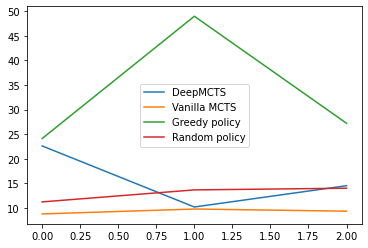


Policy Loss 2.5914832750956216
Value Loss 54.05772463480631

Policy Loss 2.5219335754712424
Value Loss 49.93256409962972
4/50
[621, 2029, 2561, 1278, 911, 2022, 1699, 1608, 548] 16.01759720062121
[1105, 2518, 2625, 2811, 424, 2766, 1650, 562, 165] 15.577106242630379
[1132, 2804, 2079, 2329, 812, 22, 1537, 2631, 1058] 12.190464781876141
[2455, 2226, 1334, 2252, 1689, 1118, 1896, 544, 451] 17.96707222273782
[908, 2533, 1309, 2434, 2121, 1739, 544, 458, 1518] 11.601636766741382
[1237, 2447, 2402, 2371, 1872, 49, 2854, 1380, 2244] 14.267912880281244
[764, 1550, 2518, 1222, 1708, 1444, 1210, 1766, 1947] 17.450408663870068
[2399, 1442, 1801, 1643, 1325, 2720, 872, 1029, 573] 15.959113886994592
[153, 2836, 1017, 1613, 2143, 1585, 748, 988, 2020] 16.602594853679463
[885, 910, 2514, 1067, 883, 954, 2120, 242, 514] 16.240924367060146
[1224, 2265, 42, 1450, 2863, 2670, 4, 1708, 431] 10.629671564991034












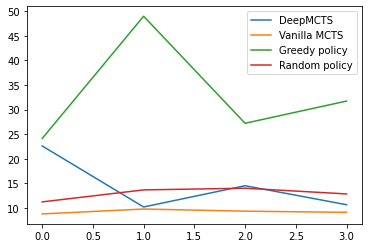


Policy Loss 2.3473551273345947
Value Loss 26.430284023284912

Policy Loss 2.3387428323427835
Value Loss 26.414803902308147
5/50
[720, 2382, 278, 1068, 2434, 1558, 1278, 2633, 1167] 12.800043337171944
[2879, 1679, 1979, 763, 2430, 723, 2489, 2113, 1923] 16.29476229190188
[791, 1322, 2354, 2601, 1885, 1005, 103, 2039, 552] 18.76939819620444
[1232, 458, 1157, 1383, 539, 2602, 2858, 160, 1917] 12.583317528311628
[1252, 831, 95, 175, 2681, 2675, 1204, 1006, 2305] 11.10238274112776
[2766, 2094, 1443, 2850, 1550, 645, 0, 855, 1689] 15.895101679556953
[673, 1567, 929, 908, 2052, 1872, 862, 748, 1572] 15.583682688946817
[2549, 2186, 2072, 624, 230, 711, 2657, 2735, 439] 16.806231954340255
[278, 2382, 1197, 925, 1645, 1508, 1906, 1071, 1279] 16.535651957650906
[2116, 1509, 1271, 938, 1592, 418, 67, 2635, 1984] 17.145508212160255
[1150, 849, 423, 689, 290, 2536, 1089, 1904, 858] 16.930344562011953












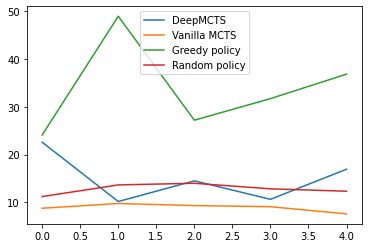


Policy Loss 2.3205676476160684
Value Loss 15.369911988576254

Policy Loss 2.3189225792884827
Value Loss 13.577112277348837
6/50
[1803, 2591, 1609, 2446, 2144, 2102, 1997, 869, 1110] 15.481906208915934
[1259, 2702, 1239, 212, 1385, 1117, 592, 494, 1094] 14.25815084949217
[1050, 1196, 1161, 582, 2548, 1608, 2327, 79, 2646] 14.13228218665492
[2826, 2674, 994, 2340, 3, 208, 1685, 1381, 1481] 12.915033250266111
[2645, 1193, 2203, 2628, 212, 1659, 1915, 1508, 1551] 16.040044638829983
[1667, 31, 1148, 685, 2519, 1568, 806, 2865, 1152] 16.00593885978086
[1677, 2348, 1829, 917, 223, 2449, 211, 124, 237] 15.659479631034628
[2736, 1237, 1927, 1138, 1140, 1736, 1429, 647, 1081] 14.368336481858249
[2360, 1722, 185, 508, 30, 2844, 606, 1616, 2427] 13.469330126309183
[1229, 1128, 219, 1960, 797, 1310, 2757, 2536, 2654] 14.816538970480496
[481, 2116, 722, 773, 1838, 2812, 131, 2094, 1150] 9.924302458653369












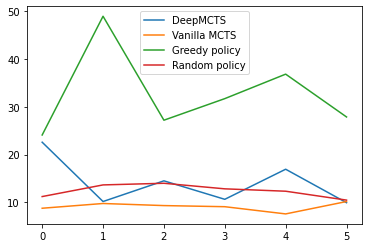


Policy Loss 2.31533936659495
Value Loss 8.22459348042806

Policy Loss 2.3129992882410684
Value Loss 5.78246541817983
7/50
[2519, 2842, 1547, 1887, 1890, 472, 1216, 2254, 1939] 14.433756805087244
[1338, 2814, 772, 1007, 904, 915, 258, 174, 459] 14.836256811324729
[972, 421, 1726, 2028, 567, 1636, 1879, 1393, 14] 13.045052461224437
[1841, 2342, 2460, 423, 1814, 1878, 838, 2582, 2202] 14.599770108682662
[2007, 1263, 2357, 2218, 1923, 636, 2840, 1624, 570] 16.79370332614094
[2, 2628, 2197, 147, 1814, 1405, 1928, 1481, 1973] 13.385467704852271
[2752, 2371, 311, 2252, 2311, 2038, 153, 690, 1464] 14.783097217023396
[792, 723, 1180, 1229, 1412, 2202, 2524, 162, 1979] 14.828681901017585
[2283, 1708, 92, 2825, 1029, 157, 843, 770, 2583] 14.376968281442142
[2087, 1204, 1629, 264, 2629, 261, 1216, 1875, 256] 15.90260601253072
[2173, 2536, 1150, 2456, 2438, 2122, 503, 131, 247] 13.130274966797614












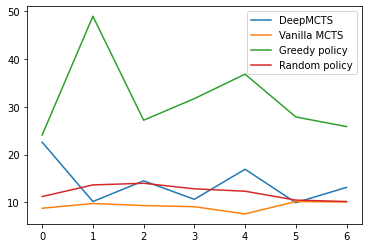


Policy Loss 2.3092018365859985
Value Loss 2.100118334094683

Policy Loss 2.3087541262308755
Value Loss 2.031477880974611
8/50
[1457, 281, 222, 1899, 2177, 2418, 671, 441, 1436] 15.002086372962728
[2737, 2245, 7, 1667, 555, 815, 2533, 1395, 1260] 17.01086879974745
[1546, 2350, 762, 2368, 2335, 2344, 256, 2619, 841] 20.1366132615935
[1934, 2495, 2382, 1234, 2483, 1887, 1651, 1980, 2449] 17.465023081589568
[22, 306, 1017, 1536, 2359, 1319, 902, 2113, 1823] 16.289651974983915
[1815, 57, 1550, 1515, 1040, 2716, 261, 1335, 784] 14.862310412650473
[1788, 1706, 1526, 2158, 2057, 515, 1157, 764, 1392] 14.629996594474134
[242, 2139, 965, 114, 144, 1217, 2726, 1358, 2177] 14.378243872406257
[2619, 904, 1928, 1474, 2519, 151, 2141, 841, 313] 18.645256845958194
[378, 265, 1820, 1361, 196, 173, 2151, 1557, 1459] 13.691567810616846
[2536, 230, 884, 1838, 1500, 2430, 42, 1900, 113] 12.220674997967969












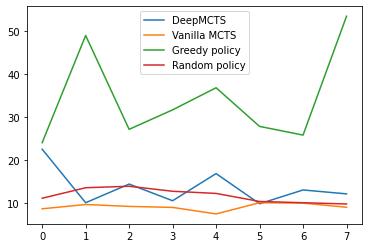


Policy Loss 2.3073074420293174
Value Loss 6.9167342980702715

Policy Loss 2.3070054054260254
Value Loss 6.300053199132283
9/50
[2061, 420, 2702, 1518, 2515, 2352, 2556, 1874, 1263] 14.361676020016073
[137, 1650, 66, 103, 734, 2143, 274, 825, 418] 12.77081586934674
[829, 1021, 1585, 2423, 1040, 2329, 2426, 892, 1459] 13.93746441742345
[1049, 2371, 2014, 1041, 2098, 2778, 687, 1392, 1600] 16.21299024596446
[592, 2476, 2800, 2345, 84, 1843, 1058, 96, 1928] 13.325571806222028
[1911, 859, 957, 1117, 1234, 281, 1841, 212, 675] 20.53087703706594
[915, 1024, 182, 14, 1381, 1209, 1720, 763, 1444] 21.753654015253925
[733, 319, 746, 1043, 508, 2119, 2592, 2022, 1855] 13.62915006136491
[599, 2295, 1024, 149, 230, 502, 1157, 988, 2164] 14.909219610871975
[2504, 2263, 1650, 403, 2203, 775, 2239, 544, 2212] 13.931751500200072
[1282, 2687, 784, 2869, 2710, 902, 1904, 482, 88] 16.74169743107008












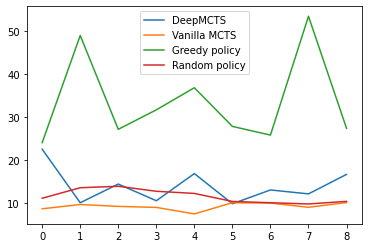


Policy Loss 2.3061325550079346
Value Loss 9.721594254175821

Policy Loss 2.305825412273407
Value Loss 9.84820814927419
10/50
[1900, 2426, 1385, 752, 2833, 2203, 2236, 1095, 2449] 11.154589865090184
[2063, 1208, 248, 2205, 2495, 1783, 677, 2606, 99] 16.91318911337692
[943, 1801, 1043, 2221, 1011, 2390, 1694, 576, 2664] 18.1103883150045
[1395, 1816, 2296, 1818, 1689, 1200, 428, 2711, 2840] 15.136631344284163
[1518, 256, 1126, 2736, 1746, 1513, 1168, 408, 2715] 12.480991021643737
[2660, 1923, 1596, 1039, 786, 2836, 1373, 137, 2814] 17.786544060268586
[2760, 2630, 119, 1324, 577, 1110, 1101, 1518, 2011] 12.890685971321803
[826, 1168, 2870, 433, 1018, 103, 2668, 592, 947] 12.181536842387983
[1889, 1455, 2148, 2529, 1603, 2028, 2360, 2323, 2434] 15.920489382435937
[542, 2269, 1460, 1433, 1252, 1404, 827, 815, 545] 11.72742130440032
[2711, 423, 1972, 2344, 1052, 1217, 4, 2094, 2438] 11.71046791943664












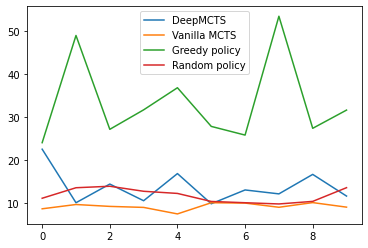


Policy Loss 2.3061458269755044
Value Loss 7.435837109883626

Policy Loss 2.3057597875595093
Value Loss 6.775291442871094
11/50
[669, 2675, 2122, 850, 2866, 1904, 2203, 2263, 1325] 12.364891639984744
[311, 162, 1603, 151, 1102, 626, 425, 2287, 1546] 21.839707575552865
[859, 2397, 308, 556, 630, 2060, 1234, 2698, 1001] 16.7331601673928
[2785, 299, 2316, 1720, 120, 644, 1110, 2518, 2882] 14.062479447639141
[1526, 482, 2539, 2833, 2334, 1472, 67, 1874, 164] 13.981351417920484
[2166, 726, 1885, 1937, 58, 2410, 492, 2197, 79] 16.99023007506451
[2670, 2529, 423, 2789, 1785, 877, 1879, 1404, 259] 16.291801089289866
[1799, 1467, 274, 672, 2414, 1975, 211, 1829, 469] 13.987664360533373
[2718, 1572, 1799, 1339, 2334, 1393, 382, 1716, 548] 16.51492260288316
[957, 2711, 2174, 306, 651, 841, 483, 2430, 249] 17.336756389828192
[4, 2604, 887, 314, 113, 1975, 2812, 2687, 503] 12.793894296882623












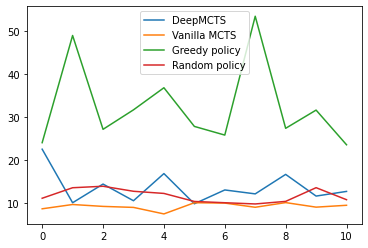


Policy Loss 2.305339256922404
Value Loss 6.968299229939778

Policy Loss 2.305240015188853
Value Loss 6.412535885969798
12/50
[748, 2445, 2657, 481, 293, 1101, 536, 2199, 2513] 17.793019587813426
[2865, 1305, 2219, 2681, 634, 141, 319, 1289, 2368] 13.313749549229478
[2609, 162, 1882, 2381, 1591, 57, 704, 2382, 2177] 15.74556442145791
[1006, 817, 2884, 353, 2858, 2026, 1687, 1523, 1581] 15.421007041440294
[1918, 2238, 1084, 722, 1157, 1086, 2569, 2656, 153] 12.955957880380543
[2666, 667, 1810, 1630, 1214, 1731, 1070, 1829, 1500] 16.993654507166976
[567, 2662, 893, 300, 2599, 2425, 859, 66, 1460] 13.65055255459394
[1869, 2666, 1128, 14, 1554, 827, 2446, 123, 1879] 18.640331155767793
[2245, 1618, 164, 1148, 2812, 1873, 1075, 908, 1188] 15.552778338381213
[433, 2167, 1442, 2750, 2303, 1167, 164, 679, 1708] 15.38485026864887
[1338, 2413, 1975, 1462, 887, 1799, 773, 1182, 88] 11.119727227244903












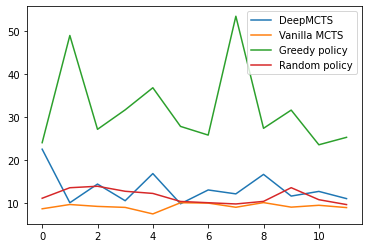


Policy Loss 2.305855909983317
Value Loss 3.8683738311131797

Policy Loss 2.3055215875307717
Value Loss 3.449845314025879
13/50
[544, 969, 2727, 2245, 2749, 2022, 690, 1401, 79] 19.06010149356949
[118, 2625, 708, 723, 1844, 2314, 1978, 1619, 2591] 14.82114108972427
[2722, 643, 2381, 1485, 1990, 1827, 1557, 1731, 2672] 13.07206302185299
[811, 1653, 490, 1264, 196, 1873, 2633, 1209, 1650] 15.378005779687387
[177, 1241, 2265, 671, 1021, 2512, 1349, 1023, 1391] 16.45466674114673
[439, 1222, 1405, 941, 41, 1527, 1263, 819, 843] 14.924036561340715
[1171, 2704, 318, 2418, 7, 566, 1915, 1518, 2127] 18.52504875838202
[2496, 2232, 2402, 1455, 584, 254, 2043, 542, 2749] 15.358066328411168
[1430, 1915, 1573, 1676, 1142, 1357, 848, 2140, 657] 16.953239724388325
[2648, 451, 2173, 2661, 274, 421, 2821, 1310, 1232] 12.97369186640545
[2061, 2536, 2413, 404, 1610, 886, 423, 2711, 73] 13.434601424554625












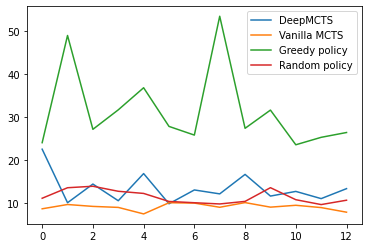


Policy Loss 2.305101156234741
Value Loss 4.858056743939717

Policy Loss 2.3049217462539673
Value Loss 3.9671477675437927
14/50
[13, 963, 2340, 2556, 655, 1748, 806, 2118, 2547] 17.050217403798783
[1529, 200, 1857, 206, 2239, 2664, 2541, 308, 546] 15.285675658604488
[1841, 2675, 992, 2397, 208, 2844, 2840, 2619, 2843] 17.29787230061544
[1975, 2635, 2329, 1271, 456, 1857, 2519, 1691, 2373] 16.865497846280793
[1325, 1042, 1270, 2226, 2460, 2412, 908, 262, 2216] 13.750463455383464
[2360, 2624, 2171, 535, 1259, 1451, 1747, 632, 1234] 14.393969870528576
[2455, 2454, 2446, 2559, 2628, 1023, 678, 1988, 2152] 13.813931980080078
[1992, 1380, 1049, 634, 1849, 131, 1603, 264, 809] 14.27960819799915
[433, 206, 1047, 1735, 559, 273, 595, 1418, 2113] 12.21663944343531
[1070, 102, 582, 97, 1634, 1041, 508, 1782, 423] 15.343898385759601
[2044, 247, 2819, 2430, 1301, 2804, 2670, 1974, 431] 11.239489691421452












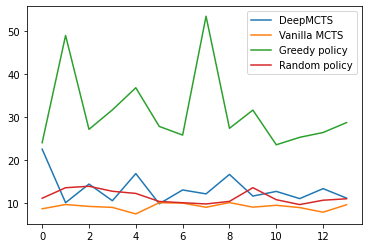


Policy Loss 2.3053855101267495
Value Loss 2.564770738283793

Policy Loss 2.3052261074384055
Value Loss 2.565595199664434
15/50
[95, 708, 2679, 1301, 1710, 2022, 258, 213, 1282] 14.400892562824545
[2518, 1555, 165, 169, 2501, 392, 545, 2644, 2698] 15.679246676953994
[2679, 1050, 2381, 884, 635, 2604, 1624, 1738, 307] 17.694813136247173
[1176, 2079, 1380, 1142, 411, 792, 2411, 207, 2152] 15.999183249373353
[1757, 1882, 2837, 93, 1947, 254, 1279, 681, 2446] 15.884475915181852
[1536, 1920, 120, 1170, 2294, 1541, 808, 1910, 1691] 17.39691531257852
[1592, 2127, 858, 2039, 7, 536, 2849, 2387, 211] 14.861892596197507
[1872, 690, 941, 2832, 219, 1379, 1025, 2282, 185] 14.868092795313355
[647, 1263, 657, 2218, 986, 1105, 1154, 1815, 2490] 14.184157310808178
[2489, 1825, 1462, 2685, 1683, 788, 915, 2395, 1597] 17.531173933231994
[2536, 1182, 2863, 886, 884, 144, 2869, 2687, 2511] 13.793456157675653












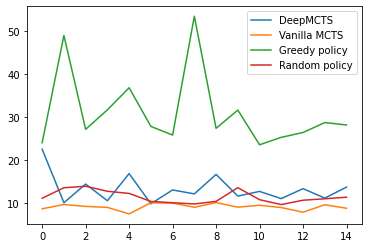


Policy Loss 2.3054891427357993
Value Loss 1.8734336098035176

Policy Loss 2.3053316473960876
Value Loss 1.717541495958964
16/50
[885, 1557, 1986, 2329, 254, 1971, 2197, 1999, 97] 15.74241118338547
[1188, 2618, 1970, 1515, 1068, 2361, 1459, 799, 169] 10.603884490681114
[1738, 2838, 2627, 2372, 577, 1786, 1545, 2058, 2850] 14.151387156806972
[2858, 1668, 1150, 831, 2749, 1825, 1202, 1237, 2069] 13.714197494997205
[892, 65, 378, 1102, 923, 2800, 2762, 25, 1662] 11.641890306395773
[2724, 141, 645, 1934, 341, 1200, 1568, 2222, 30] 13.297054647305108
[2275, 207, 394, 255, 689, 2321, 587, 938, 492] 17.77378618010984
[392, 2657, 2052, 2730, 2274, 1766, 179, 1202, 1785] 19.69729030398373
[415, 1871, 888, 983, 182, 2053, 553, 2236, 1624] 16.916497534988373
[2371, 2044, 206, 1532, 2670, 2592, 1084, 2254, 1705] 13.39740680639976
[1450, 784, 577, 88, 1974, 1701, 1999, 1182, 2456] 12.172034943733738












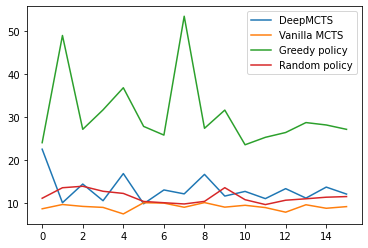


Policy Loss 2.3053884506225586
Value Loss 6.587777614593506

Policy Loss 2.305099666118622
Value Loss 7.565551161766052
17/50
[265, 2425, 2870, 923, 1928, 1357, 1176, 933, 2460] 12.615695260617834
[1224, 1232, 1208, 927, 630, 938, 1756, 1872, 859] 18.283395950393583
[1714, 1161, 772, 651, 2645, 2612, 676, 74, 24] 13.445130138146125
[275, 2539, 514, 1643, 2141, 2495, 273, 2165, 2596] 13.13773106665695
[2066, 1776, 2885, 2614, 722, 435, 2199, 2223, 2385] 13.403252361738703
[1714, 292, 1601, 437, 1638, 2787, 1415, 2702, 2026] 15.194565543202847
[2833, 437, 2601, 904, 202, 2107, 1140, 1117, 2633] 17.467625026000242
[2430, 256, 1369, 735, 2308, 450, 726, 1633, 2316] 17.248736038384617
[2619, 450, 2413, 570, 709, 225, 2838, 100, 2032] 14.55277096279402
[2191, 1020, 1142, 171, 106, 2001, 2255, 536, 545] 15.932085469507163
[1282, 2061, 425, 2430, 2536, 1232, 886, 1799, 1972] 13.867287277885824












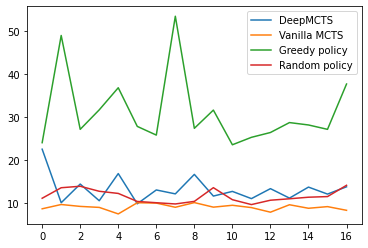


Policy Loss 2.3052101135253906
Value Loss 3.799211025238037

Policy Loss 2.3048537572224936
Value Loss 3.6891033748785653
18/50
[256, 1047, 932, 559, 74, 2582, 1857, 1643, 2059] 13.383321621231858
[511, 2053, 182, 2707, 784, 673, 1136, 1315, 2143] 13.783886181220678
[643, 1871, 2307, 2232, 23, 1111, 2854, 1166, 2885] 8.62975335002181
[1645, 1857, 1735, 441, 561, 2827, 599, 1571, 2410] 13.903972385416397
[2295, 2680, 969, 1768, 1168, 299, 1515, 1319, 2347] 14.332271568289634
[441, 1404, 1357, 45, 2350, 330, 348, 351, 2118] 18.097908899462823
[1095, 314, 1510, 264, 469, 2026, 2167, 616, 995] 14.9612196222149
[1224, 1703, 1939, 1603, 1619, 1396, 1974, 176, 2481] 13.501133530634778
[2434, 1790, 1081, 785, 2063, 1222, 1548, 2318, 1670] 16.27927127215769
[2547, 1076, 1663, 314, 2317, 1557, 1325, 1166, 589] 12.910844650582362
[1498, 2427, 2395, 872, 1455, 2344, 481, 1610, 1341] 13.092699511680433












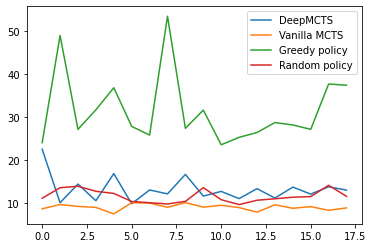


Policy Loss 2.3047768274943032
Value Loss 4.496752421061198

Policy Loss 2.3047265807787576
Value Loss 4.75458578268687
19/50
[1555, 2537, 1060, 2688, 1069, 2452, 1103, 1686, 1262] 19.295976984856967
[1413, 1543, 1040, 947, 66, 515, 26, 2245, 2425] 13.86952820631603
[2568, 2039, 167, 1401, 1899, 2528, 1691, 2232, 2514] 14.774915586493888
[511, 1887, 2806, 1312, 1485, 836, 2296, 2387, 655] 13.104684953965231
[1111, 1011, 708, 2607, 1646, 1319, 1413, 67, 1950] 13.944931382737018
[1877, 296, 784, 655, 212, 62, 1107, 215, 487] 14.749661515522824
[2174, 2672, 661, 1331, 715, 1305, 230, 355, 2521] 12.60825398878842
[1120, 1549, 1147, 226, 809, 891, 422, 2803, 223] 14.57118106733757
[965, 1731, 1081, 2232, 1042, 1989, 1934, 952, 2564] 14.503817883507951
[67, 306, 548, 2192, 2144, 1651, 2366, 1047, 2641] 13.487325797258706
[271, 1450, 1373, 2430, 2850, 2094, 1530, 1126, 655] 13.784513841852247












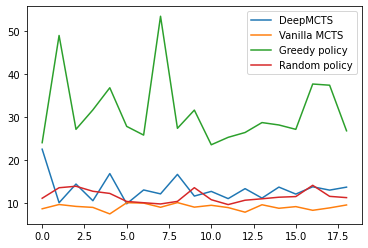


Policy Loss 2.3049405018488565
Value Loss 2.183284411827723

Policy Loss 2.3044774532318115
Value Loss 2.536650910973549
20/50
[215, 1923, 2479, 1558, 817, 1735, 2141, 2205, 2609] 15.647879417271922
[785, 2384, 1380, 2344, 2599, 1389, 1918, 1852, 2524] 12.819821354294536
[2711, 1071, 2502, 1446, 2160, 2591, 676, 177, 337] 15.449831897948583
[1442, 927, 2686, 2122, 1764, 1961, 849, 1812, 151] 13.046359360799297
[1120, 223, 1900, 1463, 1788, 963, 356, 1663, 153] 14.431045587660059
[174, 661, 52, 2060, 2673, 2323, 1677, 651, 704] 13.981494787215645
[1007, 788, 1530, 570, 1695, 2761, 1608, 2556, 2427] 17.03351623101006
[2027, 1634, 963, 2737, 413, 501, 983, 1959, 383] 17.872972424970147
[2026, 1346, 164, 1525, 2165, 2646, 1825, 364, 1920] 15.422256148775437
[603, 526, 41, 2385, 222, 356, 1709, 1075, 566] 13.557161552504313
[887, 858, 1632, 2456, 1196, 2539, 1218, 2413, 42] 11.22450531846199












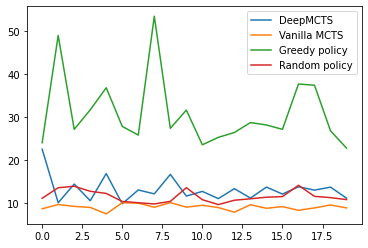


Policy Loss 2.3049473762512207
Value Loss 2.9047669967015586

Policy Loss 2.3046688636144004
Value Loss 2.4703835248947144
21/50
[2137, 1014, 792, 841, 2820, 225, 1467, 2114, 39] 16.05118055643213
[568, 2239, 447, 2624, 1325, 669, 330, 2476, 2411] 15.551631510197824
[346, 1854, 1170, 1295, 405, 1731, 2850, 2722, 2316] 13.387848666978686
[651, 1788, 628, 1271, 1738, 2457, 2836, 2806, 599] 17.558181699571914
[1384, 908, 2826, 448, 764, 2837, 2038, 897, 938] 16.68561788607768
[969, 1703, 1858, 548, 1624, 624, 688, 1216, 106] 17.714281415463617
[2145, 2146, 1763, 696, 811, 927, 1910, 1510, 1778] 11.762578851979853
[1380, 355, 2536, 464, 767, 1254, 1259, 311, 1153] 16.771697467534146
[244, 2263, 1529, 2232, 1572, 1748, 539, 132, 95] 16.512509224753224
[1161, 2619, 558, 1596, 634, 87, 1731, 1597, 943] 16.114036328877038
[1567, 73, 1052, 714, 784, 1217, 1829, 482, 1413] 11.962962916002446












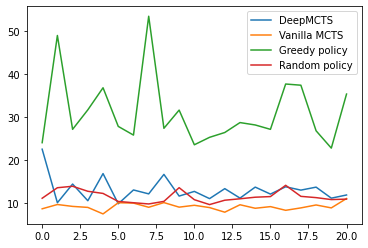


Policy Loss 2.305215756098429
Value Loss 3.9878445863723755

Policy Loss 2.3049055139223733
Value Loss 3.2267646888891854
22/50
[599, 314, 2067, 1705, 563, 2232, 404, 1392, 1443] 12.017371333144032
[883, 1435, 963, 1709, 2662, 1897, 2260, 2201, 2244] 18.08664859077737
[1912, 256, 1356, 1430, 547, 393, 1546, 933, 2467] 15.121043305620496
[2548, 2060, 1676, 2028, 1759, 1214, 2633, 157, 1222] 13.286011499191302
[1676, 1853, 1624, 1790, 2157, 1436, 1780, 1984, 1902] 20.183321586922535
[2264, 1705, 382, 603, 409, 85, 2382, 2114, 804] 15.828580382109848
[2047, 133, 1934, 355, 1610, 1202, 1107, 797, 2245] 15.273005800957993
[2014, 1368, 2561, 1263, 1430, 341, 14, 1687, 929] 16.072408325247977
[696, 1910, 1301, 30, 2412, 1452, 1748, 302, 146] 11.421969271631825
[1651, 568, 254, 986, 2704, 401, 1043, 1785, 2806] 14.517881133213358
[1610, 589, 1708, 887, 1150, 1462, 2122, 290, 1726] 12.330182698738971












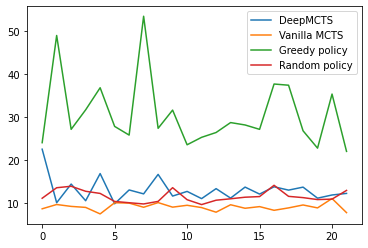


Policy Loss 2.3045395612716675
Value Loss 6.434508403142293

Policy Loss 2.3042129079500833
Value Loss 5.984117229779561
23/50
[1956, 957, 185, 318, 2177, 1821, 2654, 951, 1529] 14.115493946400205
[133, 1685, 2385, 970, 576, 1140, 1474, 988, 1] 13.994269387120108
[420, 886, 2633, 808, 1816, 30, 543, 2736, 2270] 16.457832335730018
[120, 355, 2369, 1064, 1362, 1542, 307, 2053, 1788] 14.256052864926495
[827, 908, 2380, 877, 2295, 1618, 2314, 2374, 1634] 13.611842286150898
[39, 2037, 499, 1768, 2644, 462, 1305, 998, 2814] 15.682300573957047
[831, 1184, 1103, 1358, 227, 1827, 2314, 78, 2148] 16.739213238061737
[98, 444, 216, 1695, 2300, 2505, 1848, 628, 2870] 12.282420758311613
[888, 556, 1020, 1336, 2559, 2561, 182, 114, 1068] 14.131458309432613
[1103, 2149, 2628, 1212, 572, 1722, 1438, 2615, 1532] 16.25299737019689
[314, 299, 503, 1031, 1140, 1975, 293, 2344, 1844] 13.442479423829333












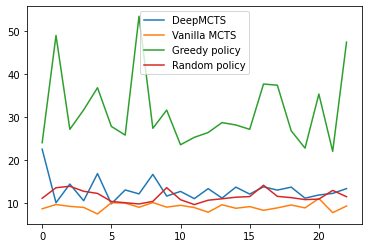


Policy Loss 2.3045061031977334
Value Loss 2.215648055076599

Policy Loss 2.304376224676768
Value Loss 2.145037223895391
24/50
[35, 2113, 1065, 1935, 1271, 760, 208, 2368, 1232] 14.027452756191847
[1117, 970, 2371, 882, 217, 1530, 2058, 2612, 373] 12.939230558720437
[1889, 1017, 70, 2423, 1489, 45, 2440, 1956, 1405] 17.46603098392651
[2816, 2212, 1310, 411, 1788, 2691, 1960, 124, 1854] 16.77596700069631
[2222, 2, 2532, 1708, 775, 809, 2670, 1102, 1663] 12.128505139570365
[2301, 1452, 1969, 641, 811, 187, 643, 1021, 2835] 13.14210441945804
[883, 1749, 2270, 462, 2524, 330, 1640, 784, 1598] 20.875739629574777
[1612, 1812, 1289, 715, 832, 1810, 1719, 2816, 744] 19.42782170943233
[1701, 902, 746, 1829, 208, 293, 1802, 784, 2865] 12.85109876560444
[1763, 1910, 95, 2490, 1952, 235, 2158, 879, 1164] 12.123229924883553
[773, 927, 714, 1115, 1218, 2566, 1232, 2869, 577] 9.307185869706313












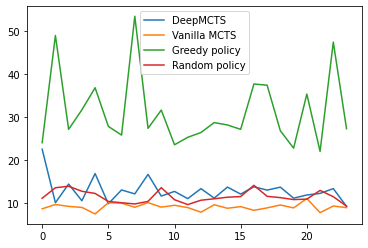


Policy Loss 2.304501930872599
Value Loss 9.056952158610025

Policy Loss 2.3043053348859153
Value Loss 8.74135955174764
25/50
[548, 1356, 1617, 1445, 1379, 2059, 2387, 2321, 1039] 14.584726116658867
[1270, 1346, 2402, 2164, 1253, 2371, 503, 314, 1164] 12.64699472512119
[1722, 2655, 2457, 889, 2423, 266, 1757, 2735, 202] 15.33596488153945
[472, 1746, 2635, 2556, 2327, 266, 1927, 885, 2489] 16.831581098680715
[222, 1259, 558, 2483, 22, 105, 871, 2645, 124] 13.785778624823692
[2479, 655, 1254, 1222, 248, 2754, 2512, 2446, 1152] 15.284121753785328
[1117, 402, 1041, 435, 2811, 2296, 1459, 2877, 1766] 13.868742499956863
[2455, 807, 2685, 2167, 1638, 1164, 844, 2561, 1950] 15.501054098160404
[971, 2862, 1799, 595, 2139, 891, 632, 2481, 2499] 13.713759655309504
[1271, 215, 1923, 1436, 2385, 232, 31, 453, 2308] 16.56072780574017
[42, 577, 1081, 1150, 2687, 299, 2711, 884, 1029] 12.677661953624959












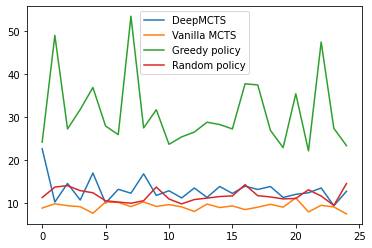


Policy Loss 2.3049691915512085
Value Loss 1.8444716731707256

Policy Loss 2.304464876651764
Value Loss 1.5969604551792145
26/50
[1976, 2205, 2804, 113, 2174, 2843, 306, 556, 490] 13.490217722892917
[1915, 943, 1016, 1346, 526, 499, 677, 497, 1877] 15.249879090960032
[689, 2532, 2439, 428, 445, 481, 2308, 2010, 196] 16.83826216242036
[1797, 1455, 1564, 1790, 616, 1506, 804, 1171, 356] 15.086401458990123
[2646, 315, 2246, 2873, 2098, 7, 84, 2329, 1554] 13.001296281605352
[987, 1510, 41, 2186, 585, 86, 1980, 2275, 364] 13.72996426798898
[1904, 711, 2269, 1887, 1070, 2358, 1797, 1510, 1804] 10.936662559273826
[1186, 1357, 1074, 2568, 1624, 1809, 564, 1782, 2730] 15.903086000695803
[1197, 1438, 209, 2158, 730, 829, 2513, 321, 1173] 16.828455968595843
[2702, 2675, 2329, 1960, 709, 2761, 95, 582, 773] 13.59843091135811
[160, 1083, 2456, 131, 2536, 1999, 832, 2711, 577] 11.874860426236745












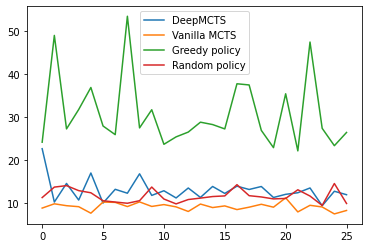


Policy Loss 2.304195443789164
Value Loss 3.333800037701925

Policy Loss 2.3040694197018943
Value Loss 2.9225501815478006
27/50
[699, 2217, 2056, 2455, 1688, 2496, 764, 1802, 977] 14.731474378635115
[2067, 2828, 2199, 2047, 1581, 217, 832, 677, 1812] 12.40476072374788
[1433, 1179, 2879, 226, 1412, 2711, 1710, 1970, 2511] 13.624252767342066
[459, 2201, 1902, 2648, 44, 1720, 2674, 1029, 674] 16.0376555572337
[2615, 1885, 2495, 2687, 2449, 1722, 1961, 1981, 1167] 15.408575905605211
[1148, 281, 2564, 987, 854, 2244, 2789, 2614, 777] 15.998521832625716
[106, 2289, 891, 1786, 1580, 165, 2604, 1197, 264] 16.32066544959421
[889, 1330, 1042, 219, 1281, 2873, 2411, 13, 2519] 13.939982717054546
[212, 1946, 307, 1281, 2194, 2106, 195, 1623, 1068] 11.610357963301173
[1764, 1436, 720, 383, 1027, 706, 801, 230, 1761] 18.26452530974067
[1462, 902, 887, 373, 2000, 849, 1500, 1999, 2687] 15.772657675763366












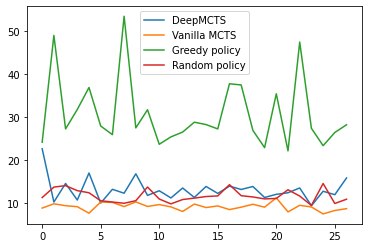


Policy Loss 2.304151256879171
Value Loss 3.4814312060674033

Policy Loss 2.303878645102183
Value Loss 3.5158971349398294
28/50
[1947, 2087, 2381, 1102, 2345, 1444, 1985, 2264, 1128] 19.19829997262519
[1555, 2502, 1618, 2871, 160, 2499, 945, 951, 685] 15.99439587999417
[1694, 433, 2618, 1556, 2339, 1310, 1969, 2666, 1975] 16.341783371722542
[1462, 2628, 2661, 2393, 566, 1939, 2687, 2140, 309] 16.023718127198197
[908, 2379, 972, 459, 1485, 2592, 306, 262, 222] 11.91199581573044
[2869, 918, 1526, 1443, 526, 1197, 1252, 1095, 50] 12.480574532911497
[2246, 2628, 2340, 1843, 1331, 542, 1498, 2384, 22] 11.747162112764023
[2145, 807, 849, 1583, 1905, 363, 42, 722, 275] 16.92749025336794
[465, 450, 296, 730, 2873, 1645, 1101, 977, 2001] 15.107318864024068
[1316, 799, 1726, 9, 403, 2839, 2456, 1965, 1472] 13.629778927202532
[2670, 290, 1284, 1282, 2202, 404, 2413, 424, 2427] 14.223697535309482












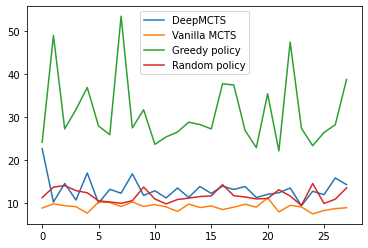


Policy Loss 2.3039358854293823
Value Loss 4.898886640866597

Policy Loss 2.3038625717163086
Value Loss 4.722597738107045
29/50
[2144, 2735, 742, 937, 1065, 2495, 2449, 2186, 2335] 15.673788254671207
[2602, 1170, 1102, 998, 1394, 1433, 2303, 2462, 858] 13.594262616019492
[1670, 405, 938, 207, 1235, 2718, 1305, 2053, 2061] 17.550211180220188
[2142, 2302, 1335, 932, 1362, 1825, 1462, 2044, 1023] 13.539612629630824
[92, 319, 309, 1737, 1518, 2119, 570, 552, 567] 11.056557729731193
[2601, 981, 458, 544, 1713, 1379, 1960, 899, 2022] 20.39447931871778
[2547, 2499, 2866, 730, 2078, 1182, 2407, 807, 1969] 14.289712358909338
[2414, 720, 2650, 1518, 1451, 652, 648, 2279, 2285] 16.26709021696535
[14, 2167, 667, 2066, 313, 299, 1981, 148, 137] 15.079867990515995
[2199, 2008, 2504, 503, 2722, 2513, 1985, 801, 1180] 16.294706840791093
[1301, 1282, 1910, 858, 899, 2566, 1991, 86, 1632] 10.421477584696806












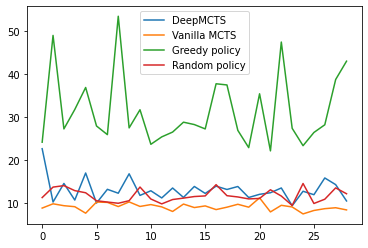


Policy Loss 2.3043278455734253
Value Loss 7.286993225415547

Policy Loss 2.304054101308187
Value Loss 5.483370075623195
30/50
[2674, 1011, 66, 422, 1336, 2689, 797, 558, 2789] 14.090267540907602
[723, 673, 1349, 2222, 157, 1655, 1601, 225, 73] 13.918541734598227
[1823, 83, 1890, 1774, 167, 651, 1218, 687, 543] 23.433514332222263
[2334, 1589, 1390, 263, 882, 2144, 1128, 1005, 2010] 16.812036919225097
[1708, 2257, 951, 1234, 146, 1022, 536, 2549, 2794] 15.228425700014789
[1749, 850, 892, 1988, 2316, 1620, 2201, 709, 2547] 12.331375774188317
[1895, 977, 752, 891, 1438, 2314, 143, 124, 1947] 15.425325738822497
[1043, 1996, 1331, 13, 634, 1526, 1572, 223, 2026] 13.346525265892826
[1537, 95, 1414, 662, 528, 2654, 1115, 791, 2447] 15.30246968199083
[1816, 195, 606, 882, 1362, 2662, 1876, 2471, 1069] 14.699398634726133
[1338, 2687, 1126, 2711, 1368, 503, 1999, 1115, 1799] 11.732643082471808












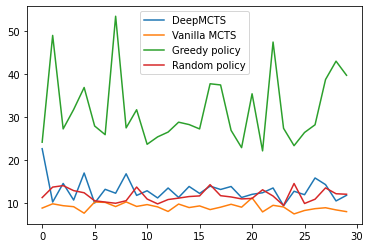


Policy Loss 2.3046703338623047
Value Loss 6.900822043418884

Policy Loss 2.304382880528768
Value Loss 6.603730022907257
31/50
[1510, 2533, 1136, 402, 2549, 84, 2457, 2721, 2811] 12.216110216173185
[1809, 1252, 1852, 983, 1976, 915, 752, 2592, 2067] 12.569937121748579
[2730, 177, 1049, 1202, 196, 1212, 213, 1065, 161] 16.266762921936586
[450, 1581, 275, 1413, 1768, 298, 2364, 2625, 2852] 15.411220925793252
[147, 1006, 294, 2681, 772, 1165, 708, 2826, 1820] 12.806532768678267
[563, 571, 1263, 2057, 2490, 295, 568, 2736, 1737] 12.247123616746597
[2, 1894, 2430, 947, 101, 1726, 715, 212, 2672] 13.042343021669188
[1778, 2108, 934, 2342, 1937, 409, 2352, 2837, 715] 15.079274130769422
[992, 847, 775, 1073, 2685, 1635, 669, 1467, 1291] 13.711244349688432
[1286, 1992, 2146, 1285, 2199, 1052, 2013, 2456, 1073] 15.444019506242864
[2427, 1089, 2000, 1284, 86, 1975, 2430, 859, 1498] 14.88849065291804












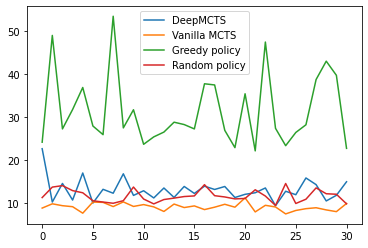


Policy Loss 2.304133137067159
Value Loss 2.5113894939422607

Policy Loss 2.3039212028185525
Value Loss 2.1169452468554177
32/50
[2832, 2095, 2118, 157, 1567, 103, 216, 66, 356] 18.483261441981814
[2334, 2849, 2657, 143, 2027, 2315, 838, 1556, 1200] 18.009083767433502
[2060, 103, 224, 1513, 2151, 734, 1352, 1600, 986] 16.130505967695054
[2884, 2827, 242, 2778, 2162, 2269, 2698, 1216, 1838] 13.965696634883342
[1580, 248, 1300, 2871, 2264, 2826, 2634, 2882, 219] 12.694816961780365
[1547, 162, 859, 1672, 356, 341, 1959, 2720, 1154] 16.379187258120396
[933, 883, 2287, 1536, 2609, 2456, 567, 869, 2303] 22.952308201337203
[1939, 482, 177, 2039, 137, 848, 780, 1232, 2279] 19.11104405531927
[1224, 791, 715, 2240, 2513, 422, 1060, 2628, 1768] 16.943264602481136
[2307, 1542, 2166, 2812, 2275, 2239, 1390, 2380, 1102] 13.474075804246421
[2812, 86, 1726, 689, 2395, 290, 1799, 2863, 88] 11.55905460347757












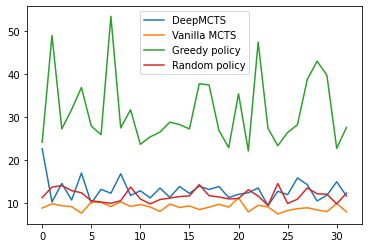


Policy Loss 2.3046693404515586
Value Loss 10.501094818115234

Policy Loss 2.3048237760861716
Value Loss 9.03013265132904
33/50
[167, 2445, 1617, 2052, 2612, 735, 1857, 1235, 153] 14.355891727173379
[2011, 1799, 434, 102, 1585, 1714, 2880, 775, 1234] 12.780936797238297
[1884, 1180, 2000, 2590, 2231, 2264, 2379, 274, 2121] 12.795965576344093
[573, 2387, 2498, 662, 2385, 1014, 413, 81, 35] 16.386049311766115
[2490, 2599, 230, 982, 1060, 1942, 1220, 57, 408] 18.682158232156336
[1278, 2633, 62, 1810, 309, 1288, 762, 2541, 1436] 22.565660576069074
[137, 2348, 1632, 2650, 1655, 2269, 2167, 118, 2125] 14.720208057666607
[103, 1474, 1640, 1415, 2402, 2511, 1111, 2171, 2174] 16.703999167453137
[2686, 483, 131, 2421, 2344, 363, 1910, 2790, 50] 16.73614489654189
[459, 1075, 235, 2245, 316, 752, 744, 423, 2670] 13.717312866576574
[1116, 2094, 1975, 299, 927, 2604, 2116, 1284, 689] 16.717040177890993












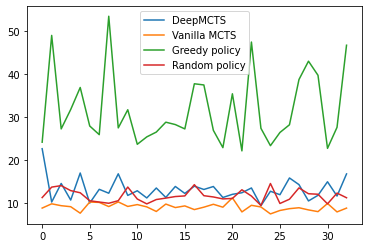


Policy Loss 2.3046857118606567
Value Loss 7.662119229634603

Policy Loss 2.3046904603640237
Value Loss 7.169063786665599
34/50
[1755, 995, 2139, 2197, 2827, 282, 1227, 887, 2246] 11.631675097719382
[742, 1039, 2238, 712, 2316, 539, 2274, 470, 2770] 20.17351565323406
[1543, 1659, 872, 1270, 114, 1217, 567, 1756, 211] 15.47473321218391
[2140, 2812, 1640, 2858, 423, 294, 2039, 1047, 2144] 12.785868431074011
[2385, 58, 1523, 2838, 2152, 213, 1176, 1735, 1591] 12.019431692859612
[1912, 49, 767, 1022, 1818, 1573, 641, 674, 1349] 13.399721115267859
[606, 2094, 1152, 2014, 1529, 1239, 826, 779, 1429] 12.502653141178914
[2513, 888, 356, 2254, 2269, 1111, 62, 63, 1074] 16.676540635252753
[1235, 2106, 162, 383, 2232, 2047, 1031, 2732, 2167] 13.374702309547152
[901, 1986, 733, 49, 2146, 58, 25, 1973, 762] 16.94587555007066
[24, 3, 2344, 1150, 1547, 39, 589, 373, 103] 11.35395963209275












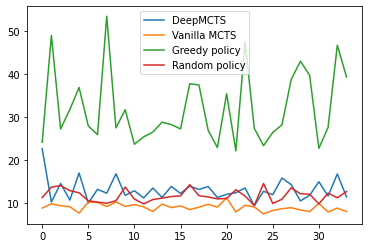


Policy Loss 2.3041892846425376
Value Loss 8.227565685907999

Policy Loss 2.303995192050934
Value Loss 6.366733888785045
35/50
[1171, 1670, 2770, 1823, 1961, 1115, 1415, 1749, 1129] 14.84494763611771
[2880, 478, 382, 2256, 2735, 103, 456, 1451, 2289] 14.928550915395602
[263, 1445, 350, 255, 1310, 2607, 547, 2177, 120] 12.836243779649305
[1683, 559, 948, 1701, 370, 1670, 428, 1780, 2379] 16.660888900083258
[2039, 1498, 1908, 1797, 963, 451, 1933, 298, 2456] 15.165544420527697
[2490, 995, 2504, 89, 2536, 2454, 892, 2680, 1519] 12.966325265960531
[1736, 319, 92, 1906, 2591, 767, 1448, 1011, 2039] 14.371602912143011
[303, 2305, 969, 1879, 2519, 2839, 2495, 1445, 310] 21.266311430598034
[564, 2878, 1918, 364, 2044, 2686, 1083, 1763, 2006] 12.500091179630987
[1237, 2137, 421, 2334, 780, 1804, 640, 619, 1567] 13.670777729200397
[1617, 2670, 1438, 2407, 2812, 1450, 1341, 887, 1196] 10.697802525701045












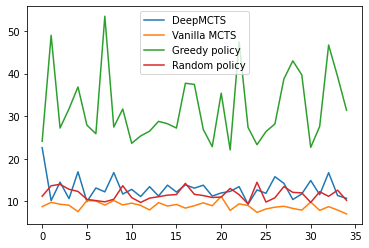


Policy Loss 2.3045891523361206
Value Loss 6.066275358200073

Policy Loss 2.304345349470774
Value Loss 4.815081357955933
36/50
[1699, 2742, 1849, 836, 2237, 1719, 1282, 2098, 1701] 14.936812423454011
[1463, 723, 1094, 2496, 2335, 2144, 584, 2337, 1887] 14.918170021729622
[2028, 2212, 1196, 2079, 577, 2010, 850, 999, 177] 20.819101201176593
[1981, 500, 1858, 1768, 2627, 2473, 1467, 1103, 848] 19.052732277155
[1527, 1810, 303, 1601, 2240, 185, 1429, 1452, 408] 15.065412173218533
[1089, 1894, 1309, 2201, 1459, 831, 2392, 1404, 171] 22.63817597830051
[2387, 2767, 2852, 1873, 1917, 801, 2666, 2812, 1285] 16.982466526138328
[2699, 1481, 99, 1748, 1643, 1219, 569, 825, 1714] 13.582156231267046
[548, 711, 1197, 148, 337, 1152, 785, 957, 1900] 13.513600734275407
[2299, 2539, 400, 2145, 281, 1475, 2787, 1279, 2051] 12.107864761095861
[927, 481, 2426, 1264, 832, 1385, 1029, 957, 2710] 15.191095720105363












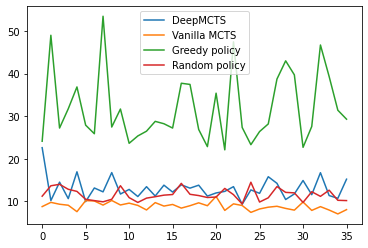


Policy Loss 2.3042104641596475
Value Loss 12.301645119984945

Policy Loss 2.3041266202926636
Value Loss 11.69377072652181
37/50
[497, 1290, 174, 584, 2502, 2333, 1007, 1684, 2113] 14.988146314238122
[1117, 2832, 2496, 1383, 1912, 2361, 421, 2173, 1141] 16.98627083146981
[838, 2625, 331, 1369, 785, 1073, 690, 2650, 2334] 16.779985843371144
[1567, 1551, 2038, 763, 2499, 161, 1591, 788, 513] 18.665704879832354
[2348, 806, 1065, 1370, 1882, 1992, 173, 2162, 2686] 14.119471920539311
[1601, 1854, 1289, 420, 2488, 1780, 313, 744, 723] 16.215333175044393
[1460, 2139, 2337, 2732, 208, 1042, 742, 668, 274] 16.006799937541203
[825, 2614, 1923, 1829, 999, 702, 2688, 1024, 619] 18.478902755230457
[439, 424, 2218, 2631, 182, 456, 1120, 355, 2299] 13.213901095811874
[1565, 1381, 2582, 1430, 212, 1482, 300, 616, 1001] 14.47156996916994
[423, 1284, 2539, 886, 1785, 899, 2710, 88, 832] 15.430244439622385












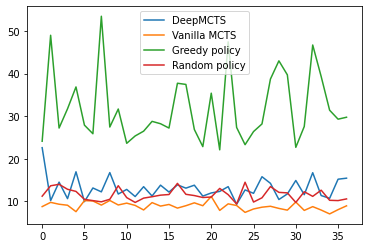


Policy Loss 2.304472287495931
Value Loss 2.5930388768514

Policy Loss 2.3041340708732605
Value Loss 2.3475789427757263
38/50
[915, 2711, 615, 2476, 2227, 1681, 934, 539, 431] 14.172181616155141
[1010, 1545, 195, 1159, 2541, 1706, 1223, 1634, 2399] 14.335514199201768
[1814, 220, 661, 1356, 1039, 2201, 1384, 2333, 2740] 12.96035061104756
[167, 321, 1536, 2660, 1937, 2299, 1820, 994, 1785] 15.603125471004951
[838, 535, 1672, 439, 1686, 1917, 278, 1006, 862] 13.513487635419839
[2137, 2656, 165, 1995, 744, 208, 1474, 1014, 1768] 21.486160177005594
[307, 2761, 1804, 171, 883, 1783, 227, 69, 1572] 21.45795411520458
[1976, 1259, 320, 2079, 1896, 1396, 411, 2427, 1110] 18.063391903715907
[1222, 561, 2849, 1567, 2814, 1154, 187, 1048, 615] 14.896532056752587
[2695, 1186, 1291, 964, 2010, 2295, 415, 752, 886] 16.313082815259545
[2812, 160, 404, 1999, 2726, 1829, 1282, 2407, 1530] 11.5998390212536












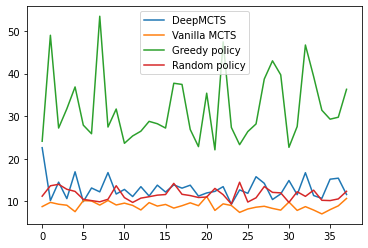


Policy Loss 2.304604450861613
Value Loss 8.006009499231974

Policy Loss 2.3043413559595742
Value Loss 7.287321289380391
39/50
[1216, 405, 730, 1882, 2629, 2456, 626, 2681, 2660] 17.92773584534266
[1027, 2028, 2528, 2418, 1157, 2670, 1600, 2548, 1635] 14.169394840192824
[2679, 445, 2641, 1052, 1065, 490, 133, 1498, 2384] 10.799728857182028
[1041, 165, 315, 2865, 829, 629, 1312, 535, 640] 13.533865724714698
[1204, 1027, 2327, 995, 1616, 2490, 641, 2302, 2223] 13.807309621634461
[2274, 67, 41, 2548, 1915, 1810, 619, 248, 2533] 14.88073314899255
[2337, 306, 1653, 888, 1558, 1152, 1004, 2172, 1947] 18.982450686901554
[2651, 2446, 39, 2742, 624, 1638, 1871, 341, 676] 12.656970972810925
[1075, 1224, 965, 624, 924, 1004, 1394, 2402, 2625] 14.705196486553756
[553, 2410, 1460, 525, 915, 951, 1060, 483, 1992] 19.807065365059355
[1844, 481, 1547, 2812, 832, 299, 2566, 425, 2710] 13.370655664849524












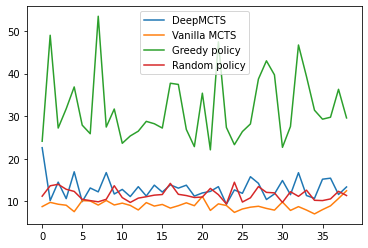


Policy Loss 2.304839531580607
Value Loss 7.5777333577473955

Policy Loss 2.304373244444529
Value Loss 6.298596143722534
40/50
[832, 553, 2393, 0, 986, 2832, 2461, 1991, 1259] 18.578005838906275
[2321, 2111, 1310, 1319, 1821, 836, 662, 973, 492] 14.746270598230435
[2397, 2651, 196, 280, 303, 848, 1450, 1523, 2529] 21.052682616328603
[311, 742, 1695, 2244, 2395, 1536, 2635, 2340, 1373] 17.009624144763464
[1004, 2321, 2541, 821, 1558, 1029, 1237, 2816, 791] 15.173150383755496
[1052, 1031, 2160, 1562, 2563, 1676, 1759, 2513, 2144] 14.793606646166351
[1064, 2452, 353, 492, 987, 3, 163, 453, 79] 13.897431552190366
[1755, 1349, 677, 1546, 1529, 445, 1937, 393, 1799] 11.329034121309762
[1020, 1383, 2592, 2395, 351, 1966, 2672, 2390, 1232] 12.037240601506376
[78, 981, 1111, 387, 547, 2666, 3, 2095, 453] 14.935843643207782
[1988, 1413, 1232, 872, 1713, 1450, 902, 88, 899] 14.07103297984278












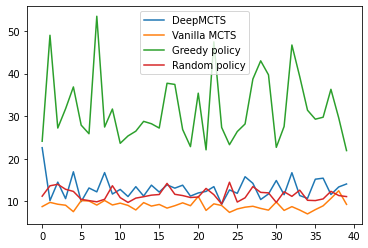


Policy Loss 2.304471254348755
Value Loss 5.750699758529663

Policy Loss 2.304439206918081
Value Loss 5.443910916646321
41/50
[132, 2007, 2707, 1358, 773, 428, 2639, 911, 1396] 15.471772590475403
[2559, 562, 1214, 303, 1118, 250, 2704, 2593, 2226] 19.44937661168243
[499, 762, 1932, 2430, 2323, 1608, 1546, 62, 139] 19.372411994411607
[1720, 1528, 1565, 1443, 2559, 595, 1624, 2299, 278] 17.593081248399972
[676, 1528, 105, 2087, 2275, 1854, 1942, 2873, 410] 15.623172082339217
[2553, 2639, 2173, 2820, 2688, 2548, 970, 309, 2059] 14.636913512008674
[2663, 2427, 223, 149, 2265, 1644, 1950, 1213, 545] 14.564233678807014
[418, 1017, 2833, 1689, 1838, 2, 807, 657, 2317] 13.845516478316075
[1583, 1875, 576, 1785, 353, 2878, 1541, 1071, 1644] 14.783681341314786
[39, 93, 483, 1736, 2167, 1636, 1892, 992, 1812] 15.752799282128787
[2804, 1301, 2061, 1217, 2850, 1829, 655, 24, 1904] 8.648009963097639












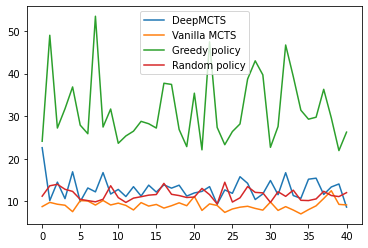


Policy Loss 2.3043998082478843
Value Loss 4.904516498247783

Policy Loss 2.3041747013727822
Value Loss 4.228635847568512
42/50
[788, 2119, 101, 1545, 2137, 2510, 1818, 1554, 273] 17.86361764518061
[2820, 1341, 2387, 237, 1396, 1726, 964, 1970, 1688] 14.051829603742057
[1859, 2732, 987, 1609, 2599, 4, 411, 1996, 1875] 16.697917969599185
[2166, 273, 1564, 1095, 826, 543, 2108, 1011, 889] 15.90639054717341
[1237, 1868, 2414, 2318, 891, 2607, 114, 2279, 572] 19.470016401162315
[1897, 1132, 2447, 2702, 2259, 1289, 1891, 2418, 1376] 16.89223515163372
[2639, 1460, 672, 1681, 1795, 2552, 1568, 1048, 1309] 15.078302208102365
[382, 1630, 2139, 2058, 937, 1522, 1168, 723, 2001] 14.370702180549966
[652, 2721, 2061, 1714, 2145, 93, 2397, 141, 1768] 17.43809859357594
[2645, 2679, 88, 492, 685, 615, 1857, 1126, 775] 13.796489775319346
[314, 1282, 2726, 899, 849, 1785, 2344, 481, 2395] 17.024990388551167












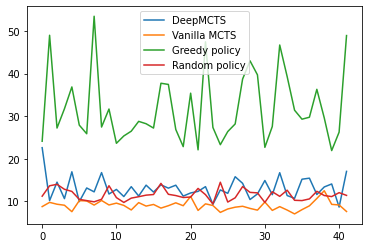


Policy Loss 2.3043861389160156
Value Loss 3.030627409617106

Policy Loss 2.304227332274119
Value Loss 2.6233822206656137
43/50
[1047, 2202, 2351, 537, 1216, 773, 2760, 2604, 1455] 12.570738847879849
[1935, 957, 1435, 1412, 2114, 1089, 573, 929, 1920] 19.083594830205975
[195, 981, 1352, 1972, 212, 13, 1572, 1877, 2833] 11.43237842327514
[2460, 2879, 1288, 616, 2232, 1555, 2295, 303, 67] 16.885665191460053
[971, 983, 1655, 1339, 806, 1317, 200, 2314, 1100] 11.12237447813086
[176, 1735, 2871, 2073, 1894, 2153, 1157, 1814, 583] 14.00970910693385
[2456, 2617, 1582, 1383, 2833, 2022, 1039, 2318, 2186] 19.412158595255576
[2219, 219, 704, 644, 2323, 943, 2559, 208, 1412] 16.592909559923264
[786, 854, 2721, 244, 843, 1644, 1435, 667, 1373] 13.191079436235409
[2091, 1324, 762, 1241, 1068, 1879, 1262, 1042, 1358] 24.92025514247166
[1632, 1218, 299, 1567, 1991, 1029, 1289, 503, 295] 9.720534630911445












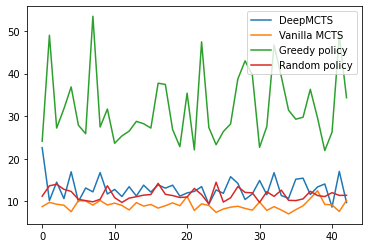


Policy Loss 2.3049890200297036
Value Loss 19.18507703145345

Policy Loss 2.3046099146207175
Value Loss 16.222214301427204
44/50
[2296, 969, 249, 165, 450, 775, 2122, 106, 1] 13.519901803354928
[1873, 987, 1336, 525, 2164, 970, 954, 2628, 1114] 15.253941728320704
[1724, 777, 1103, 2327, 1610, 2760, 315, 1526, 2219] 11.952372731355396
[2282, 1234, 420, 1756, 1882, 200, 242, 2038, 2006] 13.859859667956734
[2231, 1749, 1753, 1707, 2342, 1166, 151, 735, 1402] 13.072323379631309
[1443, 95, 1067, 1381, 2619, 13, 1324, 1018, 428] 16.019955318591663
[883, 2580, 1435, 2528, 1827, 963, 624, 2165, 2662] 15.74533688588103
[562, 224, 20, 1610, 1632, 2093, 2043, 2146, 2008] 13.61639333449488
[841, 69, 2340, 1918, 1714, 1783, 259, 704, 2238] 18.9958004332461
[2430, 337, 1859, 469, 422, 584, 1525, 2785, 2593] 14.438388017127625
[902, 1900, 1282, 2850, 500, 1264, 722, 2456, 481] 13.11520761672462












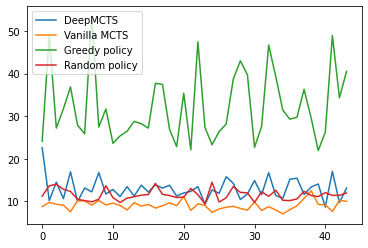


Policy Loss 2.3045204083124795
Value Loss 4.332045833269755

Policy Loss 2.3044413129488626
Value Loss 3.7176464796066284
45/50
[1247, 2219, 1179, 760, 615, 1905, 1041, 2237, 299] 16.983024317796954
[1249, 2547, 1167, 843, 483, 1714, 2221, 2139, 1624] 17.36499084167445
[2348, 2844, 2143, 105, 1790, 128, 2740, 2655, 153] 13.986031335720092
[441, 844, 2455, 2162, 2120, 1991, 2061, 764, 1523] 12.954812112582903
[1270, 2252, 69, 1736, 420, 640, 1877, 354, 2541] 13.983519271764413
[2439, 441, 1542, 2568, 1164, 648, 1739, 1083, 1975] 13.490718748954286
[1404, 174, 2391, 450, 1515, 2011, 2635, 1670, 2316] 14.979317812070844
[1816, 2238, 2295, 1980, 2007, 9, 891, 2347, 296] 15.265905483929535
[886, 2816, 844, 2137, 1843, 2466, 742, 982, 105] 15.038579524184154
[2059, 1044, 2361, 1073, 1310, 540, 441, 1017, 2222] 14.462984429561887
[1338, 230, 1975, 337, 1182, 1282, 160, 2863, 3] 12.914984403412813












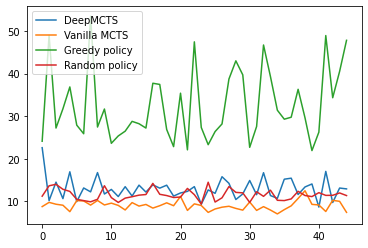


Policy Loss 2.304273764292399
Value Loss 1.8291680415471394

Policy Loss 2.3040942549705505
Value Loss 1.7739908496538799
46/50
[1590, 2633, 314, 1391, 1788, 1315, 669, 1585, 2689] 11.784689949351952
[2675, 2283, 1525, 418, 105, 817, 884, 1475, 616] 15.909473791780918
[714, 70, 313, 1670, 119, 2395, 343, 1706, 954] 14.24744136369825
[1021, 788, 982, 1869, 99, 2601, 1895, 2556, 772] 16.02543453109761
[2816, 1416, 545, 1843, 41, 742, 1393, 2702, 1396] 14.084388969860191
[1422, 1857, 224, 2490, 418, 902, 827, 2737, 1338] 15.819950114516793
[2141, 1193, 2232, 1039, 405, 101, 394, 114, 2098] 17.115950482511515
[492, 2318, 2686, 83, 885, 1100, 1816, 788, 605] 23.840690207370606
[1020, 482, 2000, 79, 1567, 42, 1749, 66, 1532] 12.646548364108032
[1529, 2606, 2761, 657, 859, 156, 2641, 69, 1271] 16.868091721322944
[42, 2093, 1115, 500, 1373, 1083, 3, 2173, 1284] 11.101508477074237












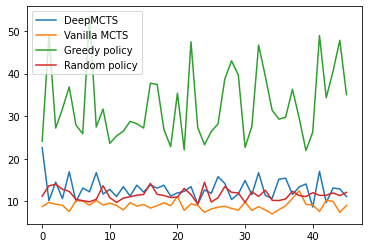


Policy Loss 2.304529309272766
Value Loss 8.525537451108297

Policy Loss 2.3042800227801004
Value Loss 7.9889868299166364
47/50
[2368, 242, 2051, 1120, 2843, 2688, 1436, 2006, 434] 24.55542195639095
[2510, 1592, 1804, 2651, 1141, 2663, 2801, 2646, 418] 13.276129027471033
[14, 1608, 216, 702, 1825, 2047, 1667, 1315, 2277] 12.361570687984651
[1810, 850, 1413, 2863, 556, 1393, 483, 293, 2218] 15.903085848984086
[1262, 2308, 657, 2087, 2127, 1858, 791, 2118, 2667] 23.98620274631163
[1485, 202, 295, 2393, 1492, 1739, 1804, 1081, 1105] 12.598666085349382
[924, 2645, 1565, 1820, 1067, 2590, 938, 2280, 2582] 13.702556383656908
[2270, 1934, 2020, 2146, 319, 2714, 2742, 2663, 2687] 16.250794532301377
[1285, 497, 24, 1970, 1150, 281, 2192, 1766, 2752] 12.109406233366741
[1380, 735, 869, 2801, 1694, 2592, 3, 1829, 2609] 15.521097171819846
[2604, 1991, 1089, 2536, 1338, 39, 1115, 1829, 2000] 12.08347064609423












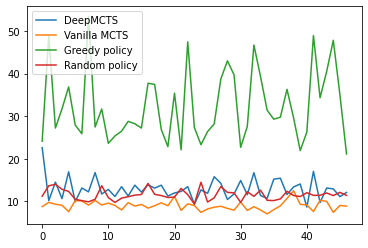


Policy Loss 2.30542520682017
Value Loss 18.98812659581502

Policy Loss 2.304904341697693
Value Loss 18.369502147038776
48/50
[2144, 1312, 1086, 595, 720, 1915, 911, 1609, 988] 14.460482768892938
[1927, 2387, 1952, 2108, 1319, 2107, 1254, 2588, 621] 14.203539644356264
[730, 1812, 1526, 1369, 230, 2720, 1218, 1852, 2151] 19.110220652655656
[772, 244, 2601, 378, 2140, 2232, 994, 2368, 564] 12.480630146344648
[3, 1284, 307, 651, 1083, 648, 1912, 2650, 2702] 15.620380578630353
[585, 1070, 2602, 153, 667, 1672, 786, 556, 319] 11.434740000078854
[2697, 100, 2380, 2423, 2826, 1525, 1567, 1157, 249] 13.240647955331923
[2737, 2073, 298, 1532, 1670, 213, 1195, 908, 2479] 18.043755014376327
[237, 170, 1689, 747, 1446, 410, 1309, 2612, 298] 16.199493309410673
[827, 176, 353, 621, 872, 1586, 1889, 2440, 1357] 17.473225983738264
[2426, 2687, 2711, 1991, 2456, 1610, 1455, 957, 431] 13.694237567900057












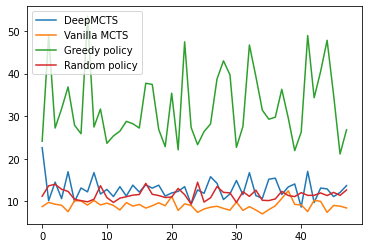


Policy Loss 2.304694096247355
Value Loss 4.755592743555705

Policy Loss 2.304609775543213
Value Loss 4.491495470205943
49/50
[2669, 2688, 2495, 1973, 1330, 621, 1223, 249, 2830] 14.311736032074672
[508, 2662, 1270, 1672, 2288, 483, 1016, 2761, 904] 16.56876533232356
[1809, 1818, 2265, 353, 1971, 2282, 1782, 2149, 933] 16.21271586689656
[2721, 1105, 249, 786, 1756, 425, 67, 2871, 999] 13.183166270059932
[2287, 478, 171, 2588, 927, 2414, 321, 2380, 2533] 16.64591561690259
[994, 2727, 1058, 221, 696, 1684, 1960, 2529, 1084] 20.24527243526954
[1235, 124, 1491, 746, 2295, 120, 2029, 511, 2334] 13.340376994234221
[636, 2066, 1776, 616, 785, 124, 2495, 572, 482] 16.34199176497703
[1887, 2295, 702, 103, 668, 2806, 2106, 2151, 1522] 14.414674102967412
[951, 994, 2390, 2231, 1573, 2858, 1820, 689, 963] 16.28194707138264
[2819, 1999, 2265, 1289, 1610, 1904, 1713, 2427, 24] 11.073681281943623












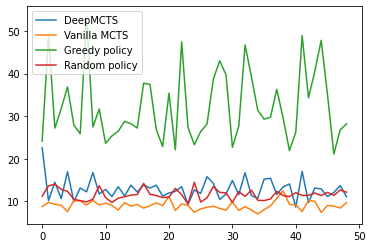


Policy Loss 2.3054036696751914
Value Loss 4.002003630002339

Policy Loss 2.305032432079315
Value Loss 3.694993317127228
50/50
[23, 2624, 2303, 1858, 1405, 2414, 459, 606, 2105] 16.076488767911822
[2352, 799, 1324, 2287, 640, 1927, 2674, 2726, 2670] 15.173862734627539
[2173, 1254, 1081, 2564, 2612, 847, 1778, 1726, 860] 11.395364895179675
[2280, 965, 310, 568, 2282, 2344, 1613, 1651, 1990] 15.479117256877633
[39, 2039, 2650, 79, 1060, 365, 998, 569, 1451] 13.570146240929292
[2814, 1336, 171, 2275, 2160, 1369, 1491, 315, 2060] 16.881893541156625
[50, 812, 2395, 31, 2447, 1763, 1640, 2513, 176] 15.956744529877522
[1643, 543, 1554, 726, 636, 841, 648, 1653, 2511] 17.307184034966202
[1708, 14, 911, 1500, 938, 2340, 1902, 1362, 2314] 21.06172585504982
[224, 1737, 2282, 1965, 2830, 114, 66, 2845, 1295] 15.345803860576302
[2335, 564, 1900, 1264, 1232, 73, 1972, 2710, 1338] 9.229403891339212












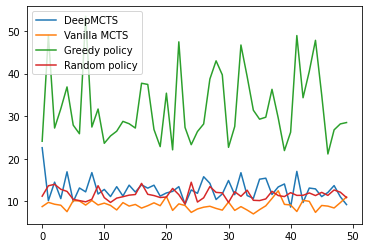


Policy Loss 2.304220716158549
Value Loss 5.167169173558553

Policy Loss 2.304039935270945
Value Loss 5.074403256177902


In [15]:
import torch
import math
import pandas as pd
import numpy as np
import random as rand
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

import scipy.spatial.distance as distlib
playlist_length = 10
n_clusters = 20 # Also equals to the action space size
model = MDP('MSD.csv', playlist_length, n_clusters)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = {
    'batch_size': 16,
    'numIters': 50,                                # Total number of training iterations
    'num_simulations': 10,                         # Total number of MCTS simulations to run when deciding on a move to play
    'numEps': 10,                                  # Number of full games (episodes) to run during each iteration
    'numItersForTrainExamplesHistory': 20,
    'epochs': 2,                                    # Number of epochs of training per iteration
    'checkpoint_path': 'latest.pth'                 # location to save latest set of weights
}

dl_model = Connect2Model(model.n_features*model.playlist_length*10, n_clusters, device)
# print(model.n_songs)
trainer = Trainer(dl_model, model, args)

trainer.learn(1)
data = {"MCTS": trainer.scores_mcts,
        "MCTS_DL": trainer.scores_mcts_dl,
        "GREEDY": trainer.scores_greedy,
        "RANDOM": trainer.scores_random}

with open(filepath+'{}_{}_{}_{}.pickle'.format(datetime.now().strftime("%y%m%d%H%M%S"), args['numIters'], args['num_simulations'], args['numEps']), 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(filepath+'{}_{}_{}_{}.pickle'.format(datetime.now().strftime("%y%m%d%H%M%S"), args['numIters'], args['num_simulations'], args['numEps']), 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
keys = list(model.clusters.keys())
keys[0] in model.clusters[keys[0]] 

True

In [ ]:
print(model.init_prefs)

print(model.filtered_df)

print(model.MC_value(root))


     0    1    2    3    4    5    6   ...   73   74   75   76   77   78   79
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0
12  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0
6   0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0
11  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0
9   1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0

[5 rows x 80 columns]
     duration  key_confidence  ...  artist_hotttnesss  song_hotttnesss
0   252.05506           0.777  ...           0.394032         0.542899
1   156.55138           0.808  ...           0.356992         0.299877
2   318.45832           0.764  ...           0.406985         0.463490
3   273.18812           0.226  ...           0.373679         0.449940
4   262.26893           0.038  ...           0.410229         0.212045
5   216.47628           0.564  ...           0.446733         0.270776
6   217.5734

TypeError: ignored

In [ ]:
print(model.phi_s)
print(model.theta_s(0))

print(np.dot(model.phi_s, model.theta_s(5)))



[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
